# Imports, loading features and DB

In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

import feature_extraction.haar_features.haar_modules as hm
from general_utils.plots import plot_froc, plot_bootstrap_froc
from metrics.metrics import froc_curve, froc_curve_bootstrap
from general_utils.plots import plot_bboxes_over_image
from mc_candidate_proposal.candidate_utils import balance_candidates
from metrics.metrics_utils import (get_froc_df_of_img, get_froc_df_of_many_imgs_features,
                                   get_tp_fp_fn_center_patch_criteria)
from mc_candidate_proposal.morphology_mc import MorphologyCalcificationDetection
import matplotlib.pyplot as plt

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_diam_mm=1.0,
        partitions=['train', 'validation'],
        extract_patches=False,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

# Classification

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler


from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [4]:
hd = MorphologyCalcificationDetection(rbd_img_path='/home/vzalevskyi/projects/calc-det/data/recounstructed_by_dialation_img/new_rbd',
                                      threshold=0.96, min_distance=6,
                                      area=14*14, filter_muscle_region=True, )

## Split data into 2 chunks, otherwise impossible to fit in RAM

In [5]:
first_half_imgs = [20587054, 20587080, 20587148, 20587174, 20587200, 20587226,
                   20587294, 20587320, 20587346, 20587372, 20587466, 20587492,
                   20587518, 20587544, 20587612, 20587638, 20587664, 20587690,
                   20587758, 20587784, 20587810, 20587836, 20588308, 20588334,
                   22580015, 22580038, 22580068, 22580098, 22580654, 22580680,
                   22580706, 22580732, 22613770, 22613796, 22613822, 22613848,
                   22613918, 22613944, 22613970, 22613996, 22614074, 22614097,
                   22614127, 22614150, 22670278, 22670301, 22670324, 22670347,
                   22678953, 22678980, 22679008, 22679036, 24055149, 24055176,
                   24055203, 24055274, 24055328, 24055355, 24055382, 24055573,
                   24055600, 24055627, 24055654, 24055725, 24055752, 24055779,
                   24055806, 24055877, 24055904, 24055931, 24055958, 24065251,
                   24065270, 24065289, 24065308, 24065380, 24065407, 24065434,
                   24065461, 24065530, 24065557, 24065584, 24065611, 24065680,
                   24065707, 24065734, 24065761, 24065833, 24065860, 24065887,
                   24065914, 26933772, 26933801, 26933830, 26933859, 27829134,
                   27829161, 27829188, 27829215, 30011484, 30011507, 30011530,
                   30011553, 30011798, 30011824]

In [6]:
haar_features_data, haar_features_data_fns = pd.read_pickle('feature_sets/gmorph_HaarF_final.pkl')

haar_features_data = haar_features_data[~haar_features_data.img_id.isin(first_half_imgs)]
haar_features_data_fns = haar_features_data_fns[~haar_features_data_fns.img_id.isin(first_half_imgs)]

print(haar_features_data.shape)
haar_features_data.head()

(131801, 406)


haar_0    haar_1    haar_2    haar_3    haar_4    haar_5    haar_6  \
121204  0.035509 -0.151722 -0.027618 -0.024032 -0.012554  0.098637  0.050574   
121205  0.035509 -0.151722 -0.027618 -0.024032 -0.012554  0.098637  0.050574   
121206 -0.716643  -0.62769 -1.017934  0.559182 -0.795911  -0.41858  -0.49462   
121207 -0.716643  -0.62769 -1.017934  0.559182 -0.795911  -0.41858  -0.49462   
121208  0.006098 -0.112626 -0.107245  0.042324 -0.092898  0.087518  0.020445   

          haar_7    haar_8    haar_9  ... rot_haar_167 rot_haar_168  \
121204 -0.045911   0.03264  0.096844  ...     1.799857     0.545911   
121205 -0.045911   0.03264  0.096844  ...     1.799857     0.545911   
121206  0.832855 -0.244261 -0.281923  ...     2.428981      1.66033   
121207  0.832855 -0.244261 -0.281923  ...     2.428981      1.66033   
121208  0.140961  0.035868  0.057389  ...     2.903515     1.322812   

       rot_haar_169 rot_haar_170 candidate_coordinates  \
121204    -2.962339     2.616212        [662, 3094, 3]   
121205    -2.962339     2.616212        [662, 3094, 3]   
121206    -2.395983     2.487446       [1108, 2905, 4]   
121207    -2.395983     2.487446       [1108, 2905, 4]   
121208    -2.870516     2.228121       [1176, 2893, 2]   

                   patch_coordinates    img_id repeted_idxs matching_gt label  
121204    ((3087, 3101), (655, 669))  30011850          0.0        14.0  True  
121205    ((3087, 3101), (655, 669))  30011850          0.0        15.0  True  
121206  ((2898, 2912), (1101, 1115))  30011850          2.0         6.0  True  
121207  ((2898, 2912), (1101, 1115))  30011850          2.0         7.0  True  
121208  ((2886, 2900), (1169, 1183))  30011850          4.0         5.0  True  

[5 rows x 406 columns]

In [7]:
rest_features_data, rest_features_data_fns = pd.read_pickle('feature_sets/gmorph_noHaarF_final.pkl')

rest_features_data = rest_features_data[~rest_features_data.img_id.isin(first_half_imgs)]
rest_features_data_fns = rest_features_data_fns[~rest_features_data_fns.img_id.isin(first_half_imgs)]

print(rest_features_data.shape)
rest_features_data.head()

(131801, 157)


img_energy img_entropy img_uniformity   img_min img_10th_perc  \
121204  49.650478    6.663589       0.011922  0.464849      0.479914   
121205  49.650478    6.663589       0.011922  0.464849      0.479914   
121206  46.992518    7.049434       0.008486  0.433644      0.445839   
121207  46.992518    7.049434       0.008486  0.433644      0.445839   
121208  45.666409    7.132417       0.007965  0.425036      0.434362   

       img_90th_perc   img_max  img_mean img_median img_inter_quartile_range  \
121204      0.534433  0.628407  0.502481   0.494261                 0.019458   
121205      0.534433  0.628407  0.502481   0.494261                 0.019458   
121206      0.564562  0.606528  0.487543   0.469871                 0.061962   
121207      0.564562  0.606528  0.487543   0.469871                 0.061962   
121208      0.545194  0.615136   0.48052   0.462339                 0.075412   

        ... patch_glcm_dissimilarity_HL1_2 patch_glcm_dissimilarity_HH1_0  \
121204  ...                    7343.285714                           63.0   
121205  ...                    7343.285714                           63.0   
121206  ...                    7021.628571                           64.2   
121207  ...                    7021.628571                           64.2   
121208  ...                    3501.828571                      57.485714   

       patch_glcm_dissimilarity_HH1_1 patch_glcm_dissimilarity_HH1_2  \
121204                      65.444444                      66.828571   
121205                      65.444444                      66.828571   
121206                      59.583333                      64.314286   
121207                      59.583333                      64.314286   
121208                      55.361111                      47.771429   

       candidate_coordinates             patch_coordinates    img_id  \
121204        [662, 3094, 3]    ((3087, 3101), (655, 669))  30011850   
121205        [662, 3094, 3]    ((3087, 3101), (655, 669))  30011850   
121206       [1108, 2905, 4]  ((2898, 2912), (1101, 1115))  30011850   
121207       [1108, 2905, 4]  ((2898, 2912), (1101, 1115))  30011850   
121208       [1176, 2893, 2]  ((2886, 2900), (1169, 1183))  30011850   

       repeted_idxs matching_gt label  
121204          0.0        14.0  True  
121205          0.0        15.0  True  
121206          2.0         6.0  True  
121207          2.0         7.0  True  
121208          4.0         5.0  True  

[5 rows x 157 columns]

In [8]:
haar_features_data = haar_features_data.drop(columns=[x for x in haar_features_data.columns if 'haar' not in x])


In [9]:
all_features_set = pd.concat([haar_features_data, rest_features_data], axis=1)

In [10]:
pd.to_pickle((all_features_set, rest_features_data_fns), 'feature_sets/gmorph_allFeat_final_half2.pkl')

# TO DO:

**I. Cascade Classification**
1. Which features/classifiers are better to use on what stage. We'd like to know wich quick feature set can reduce number of candidates with retaining high sensitivity so we can in the next steps of cascade use more features (more complex ones) for detection?
    1. Feature extraction time by type
    2. False postivie reduction power with a goal for retaining 0.99 sensitivity

2. Build the cascaded classification. Show FP reduction and sensitivity changes of each step of cascade. Make it parametrized.
    1. Check if there is a point in using a cumulative set of features or only the new one.
    2. Check feature importances for each step of cascade.

3. Do hard negative mining. Use pool of negative samples to mine hard ones for every step of cascade training to get more robust classifiers.


**II. All features together Classification**

In [6]:
from xgboost import XGBRFClassifier

In [7]:
# features_data, features_data_fns = pd.read_pickle('feature_sets/gmorph_allFeat_final_half1.pkl')
features_data, features_data_fns = pd.read_pickle('feature_sets/hough1_noHaarF_final_1.pkl')

In [9]:
# retrieving each features set column names

fos_cols = [x for x in features_data if 'img' in x and x != 'img_id']
gabor_cols = [x for x in features_data if 'gabor_'in x]
wavelet_cols = [x for x in features_data if  x[:6] == 'patch_' and x != 'patch_coordinates']
haar_cols = [x for x in features_data if  'haar' in x]
features_sets = {'fos':fos_cols, 'gabor':gabor_cols, 'wavelet':wavelet_cols,
                'fos+gabor+wavelet':fos_cols+gabor_cols+wavelet_cols,
                 'fos+gabor+wavelet+haar':fos_cols+gabor_cols+wavelet_cols+haar_cols}


In [20]:
# need to add SVC but a fast implementation or just wait a lot
classifiers = {'XGBRF': XGBRFClassifier(n_estimators=100, max_depth=6, n_jobs=-1),
               'RF': RandomForestClassifier(n_estimators=100, max_depth=6, n_jobs=-1),
               'SVC':SVC(C=10, probability=True)}


### Casade Anal

In [9]:
# adding case_id column
imgid2caseid = db.df[['img_id', 'case_id']].set_index('img_id').to_dict()['case_id']
features_data['case_id'] = [imgid2caseid[imgid] for imgid in features_data['img_id']]

In [9]:
# features_data['raw_mask_intersection'] = 0
# for img_id in tqdm(db.df.img_id.unique()):
#     raw_mask = cv2.imread(str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
#     for idx, row in features_data[features_data.img_id == img_id].iterrows():
#         (ppx1, ppx2), (ppy1, ppy2)= row['patch_coordinates']
#         features_data.at[idx, 'raw_mask_intersection'] = (raw_mask[ppx1:ppx2, ppy1:ppy2]>0).sum()

100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


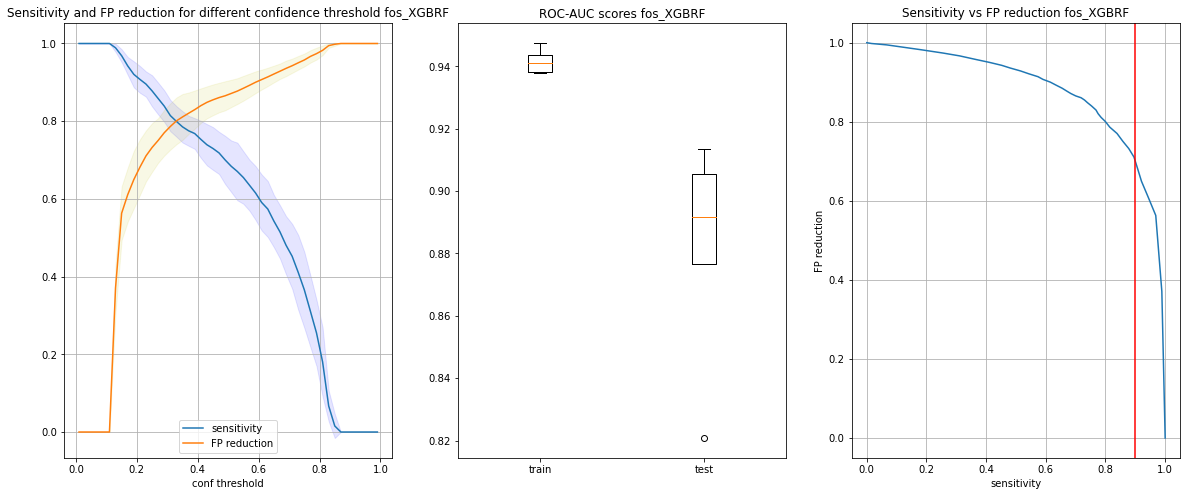

100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


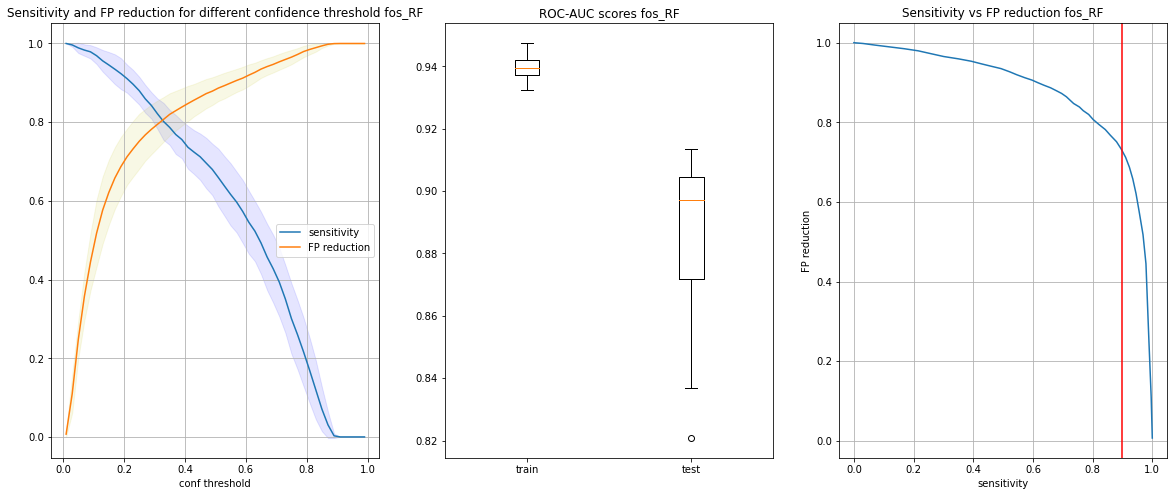

100%|██████████| 5/5 [01:56<00:00, 23.25s/it]


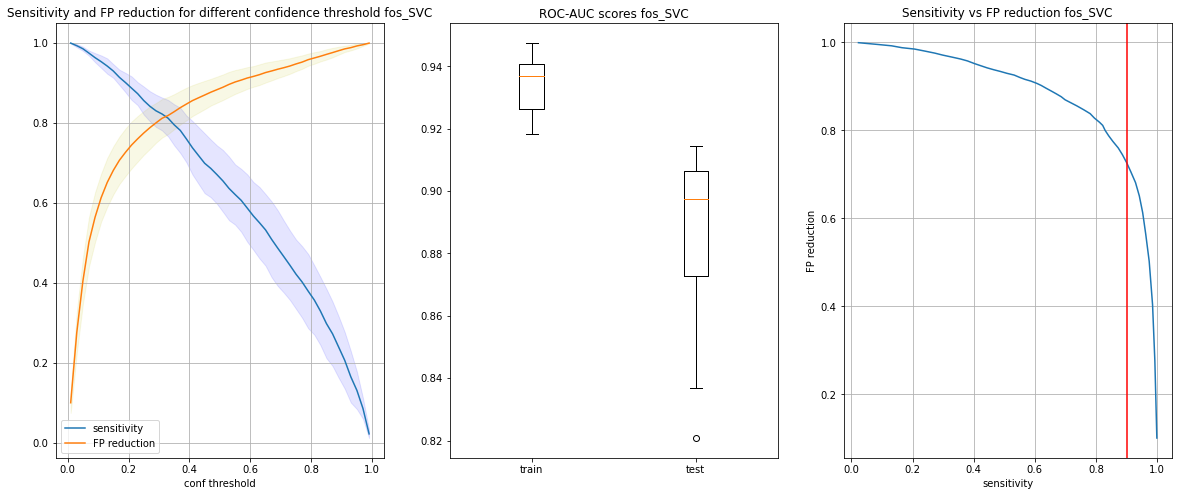

100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


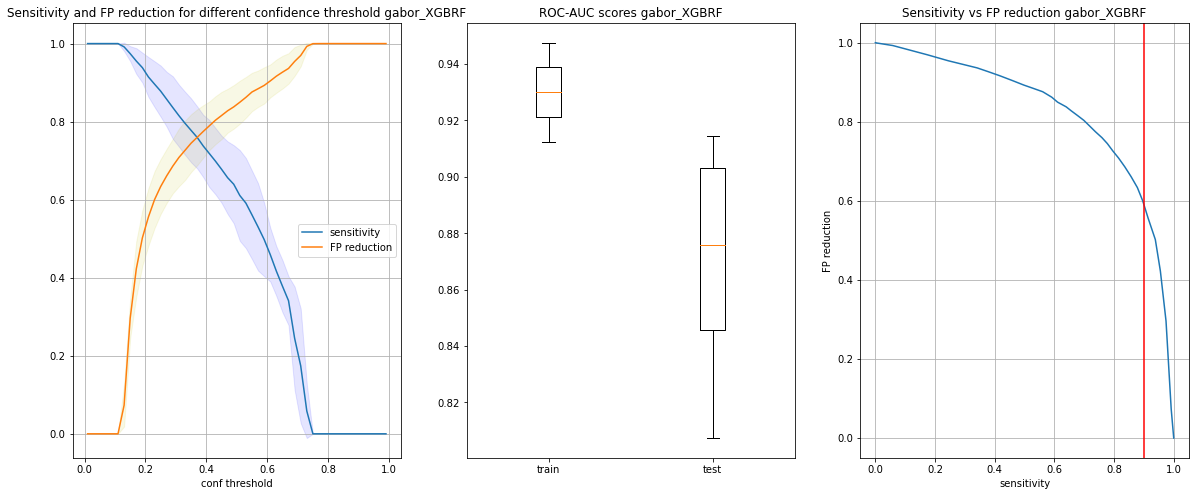

100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


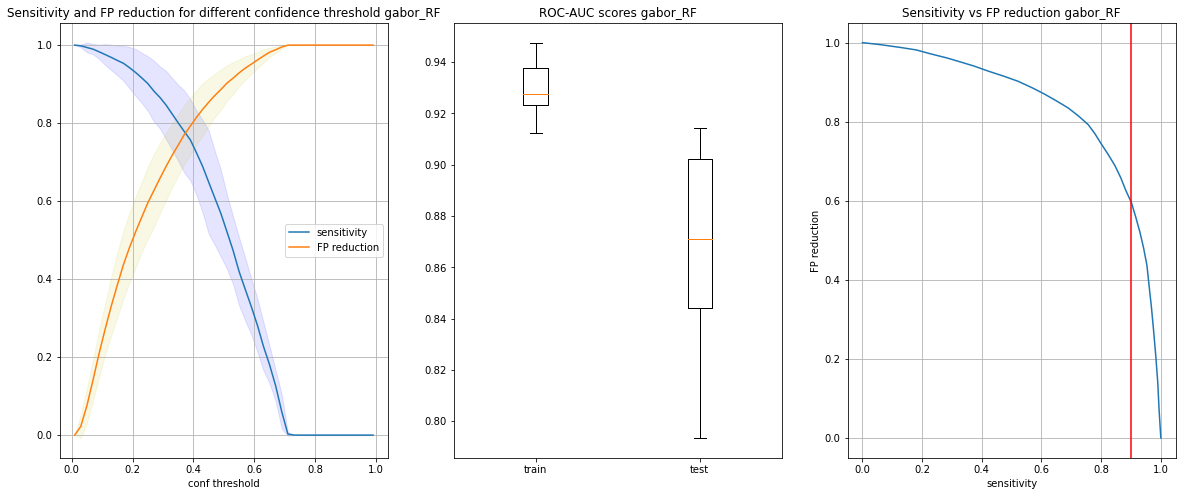

100%|██████████| 5/5 [02:25<00:00, 29.04s/it]


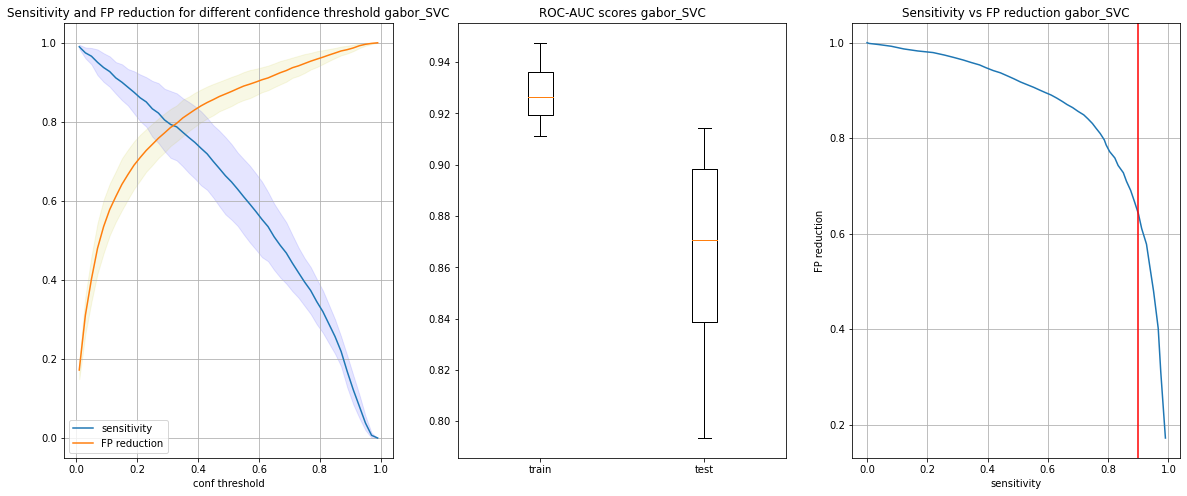

100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


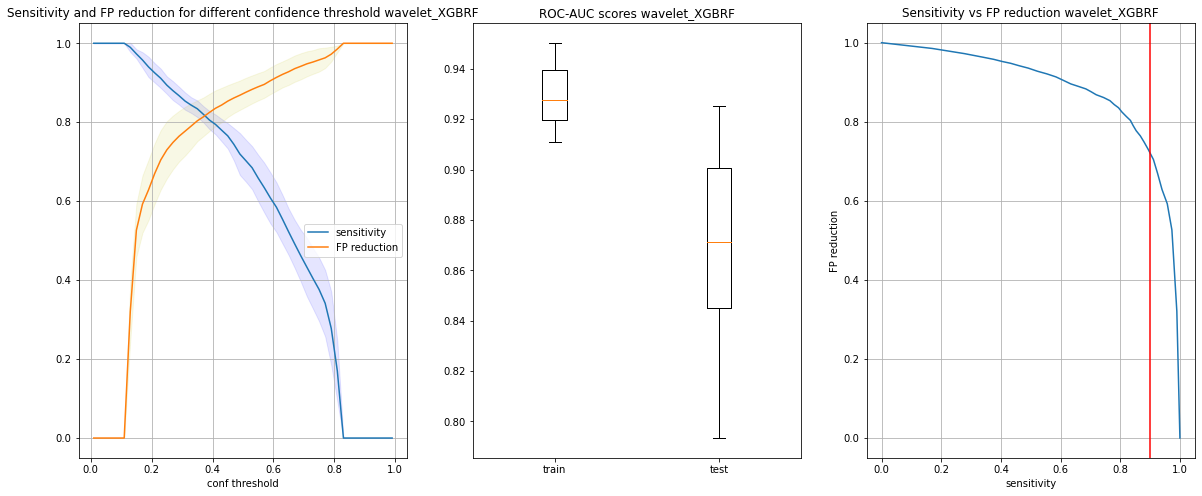

100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


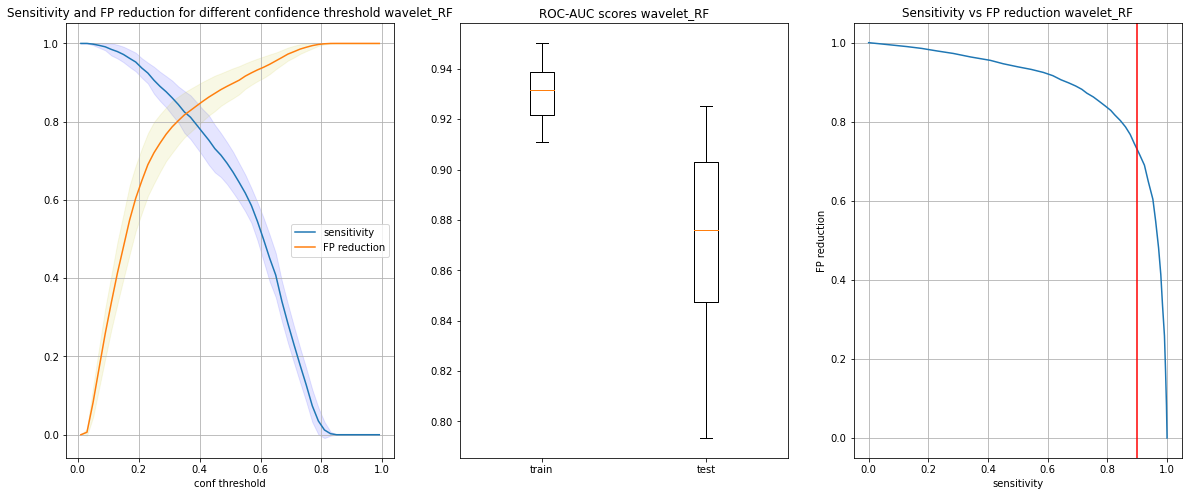

100%|██████████| 5/5 [03:02<00:00, 36.44s/it]


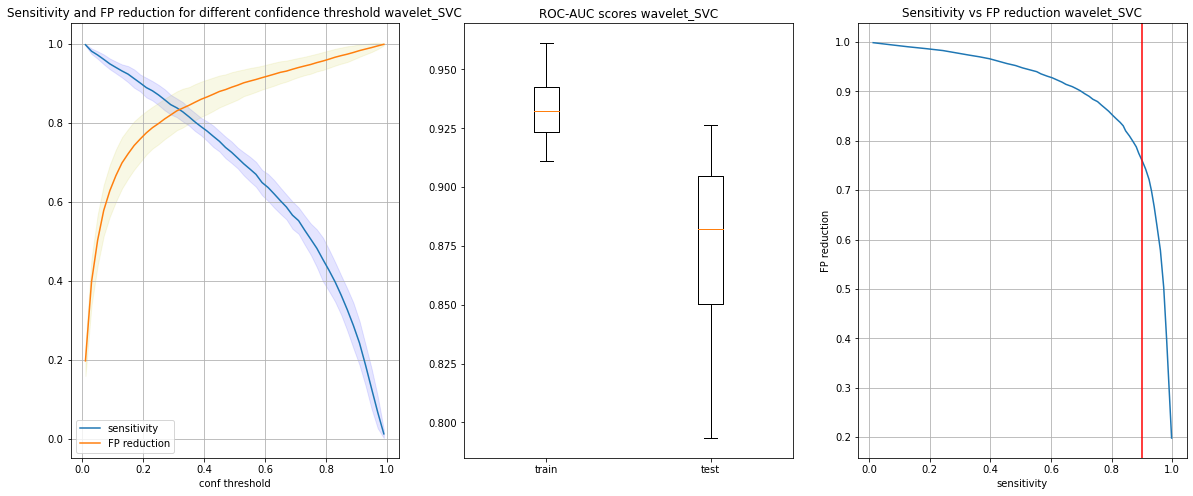

100%|██████████| 5/5 [01:07<00:00, 13.52s/it]


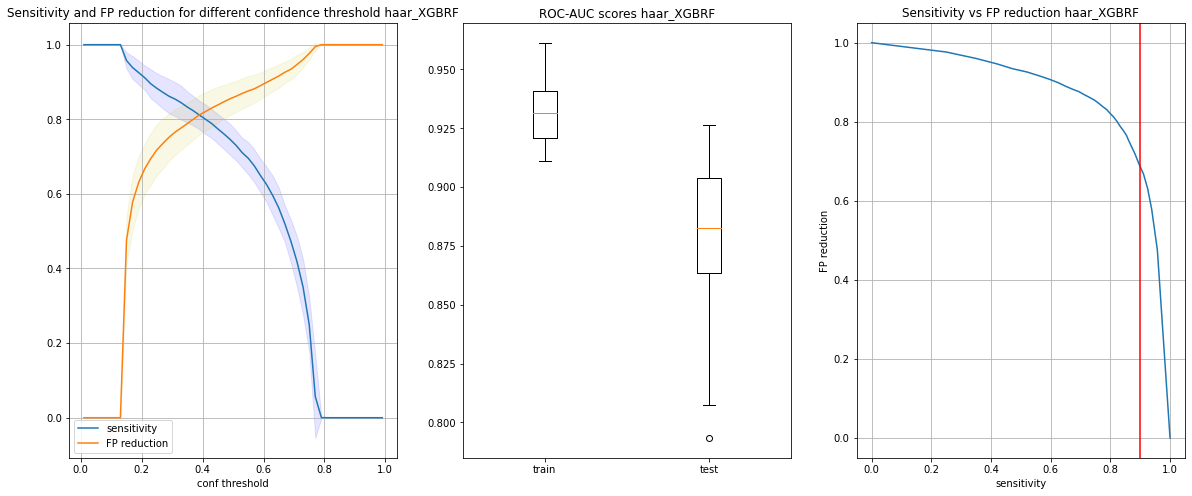

100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


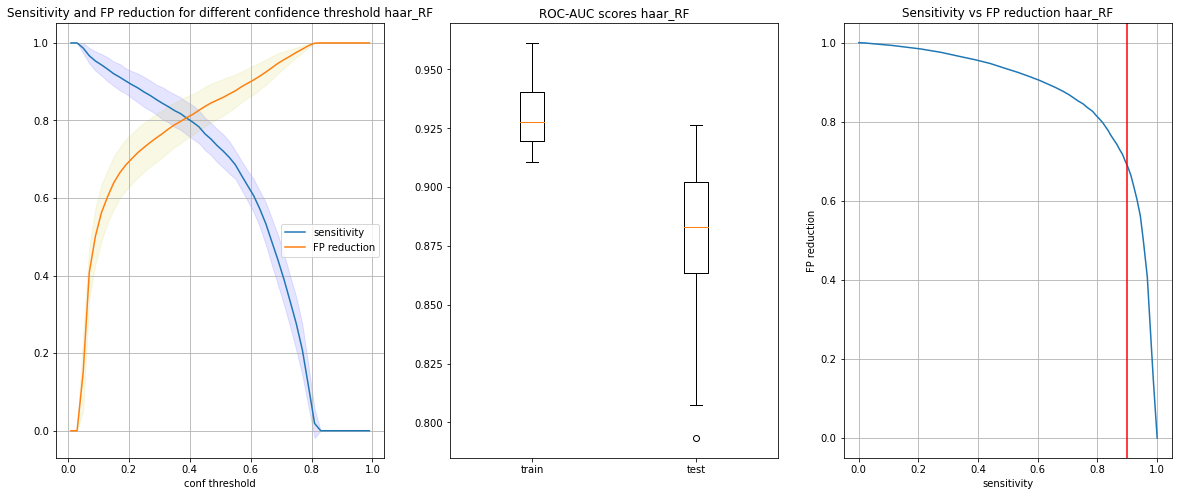

100%|██████████| 5/5 [11:59<00:00, 143.86s/it]


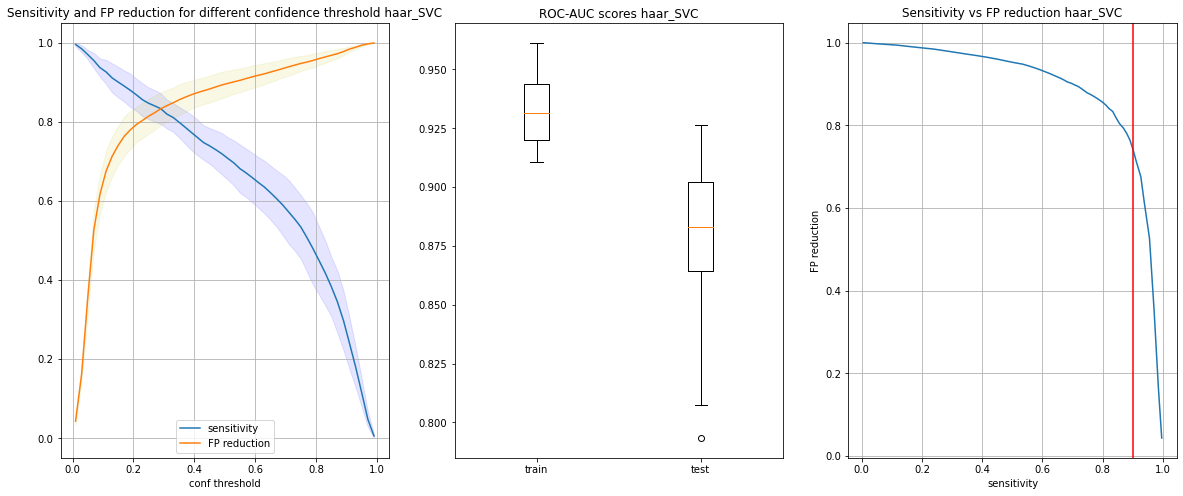

100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


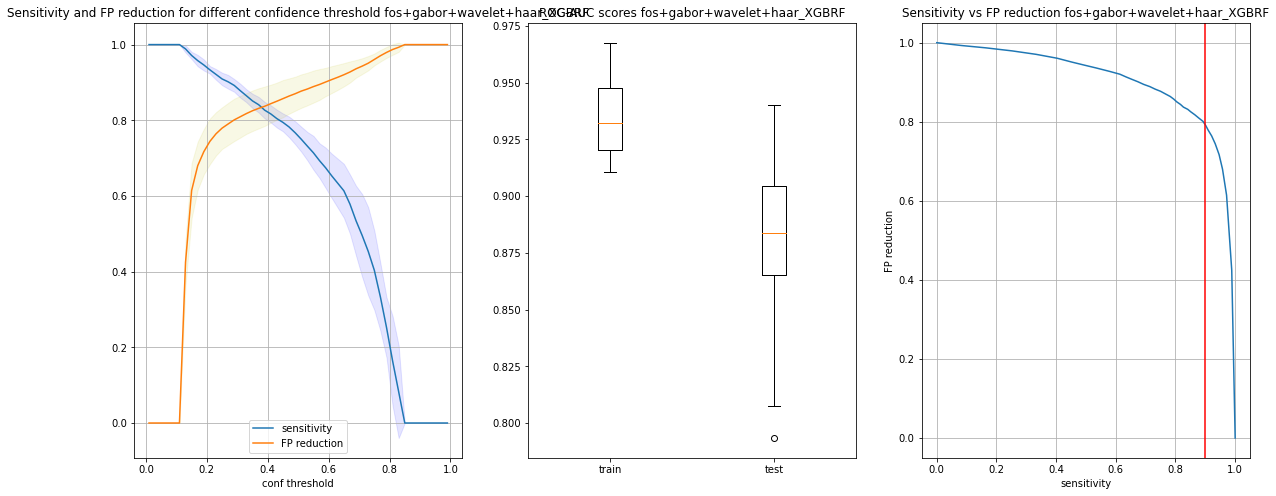

100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


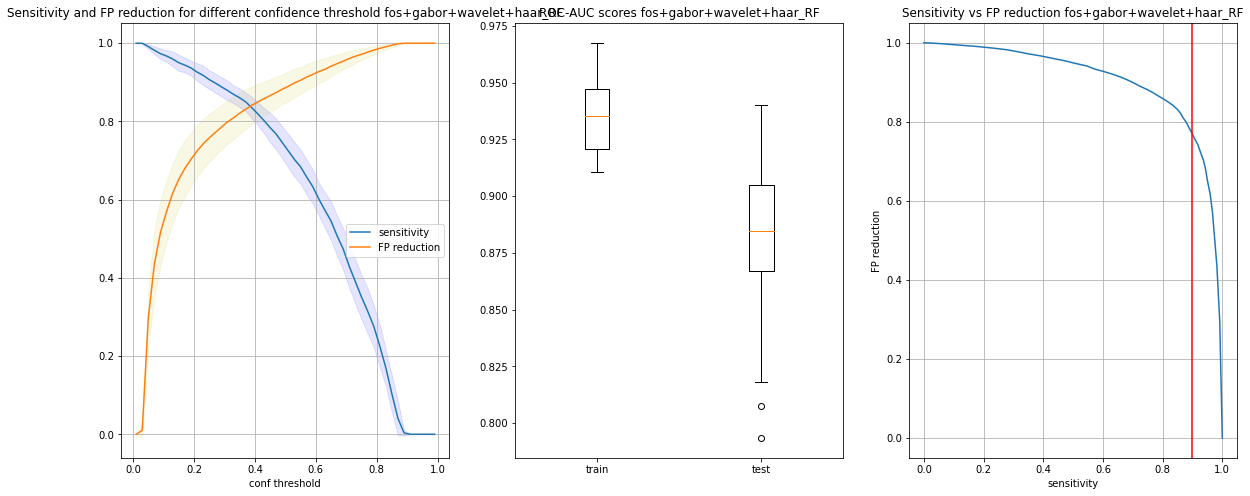

100%|██████████| 5/5 [13:09<00:00, 157.92s/it]


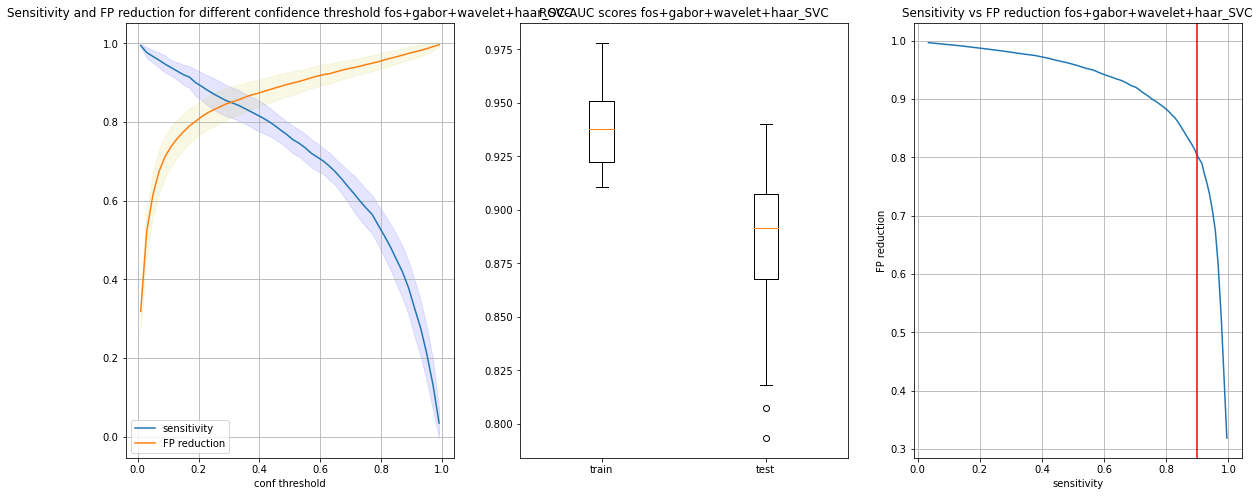

In [ ]:
kfolds = 5
FP2TP_rate = 2
desired_sensitivity = 0.9

conf_thresholds = np.linspace(0.01, 0.99)

# splitting data into train/validation case-wise
all_case_ids = features_data.case_id.unique()
kfolds_case_splits = np.array_split(all_case_ids, kfolds)

roc_aucs = []


# classifiers = {'RF': RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1)}

results = {}

for feature_set_name, features_set in features_sets.items():

    for clf_name, clf in classifiers.items():
        
        fpr_sens_curve = []

        # kfold CV
        for valid_case_ids in tqdm(kfolds_case_splits):

            # split data into test
            test_split_mask = features_data.case_id.isin(valid_case_ids)
            
            # split into train and take into account cleaned data with no mC in the borders of the patch
            cleaned_features_data = features_data[~test_split_mask]
            
            # and sampling to a predefined 1:FP2TP_rate TP:FP samples
            positive_mask = (cleaned_features_data.labels>0)
            positive_train_part = cleaned_features_data[positive_mask]
            negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum()) # INGORING SAMPLING
            
            train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)
            
            
            
            test_df = features_data[test_split_mask]
            
            train_y = train_df.labels#.astype(int)
            test_y = test_df.labels#.astype(bool)
            
            scaler = MinMaxScaler()
            train_X_scaled = scaler.fit_transform(train_df[features_set].values)
            test_X_scaled = scaler.transform(test_df[features_set].values)
            
            clf.fit(train_X_scaled, train_y)

            train_y_predicted = clf.predict_proba(train_X_scaled)[:,1]
            test_y_predicted = clf.predict_proba(test_X_scaled)[:,1]
            
            roc_aucs.append((roc_auc_score(train_y, train_y_predicted),
                            roc_auc_score(test_y, test_y_predicted)))
            
            sens_fpr = []
            for pred_thr in conf_thresholds:
                test_y_pred_binarized = (test_y_predicted>pred_thr).astype(bool)
                TP = (test_y & test_y_pred_binarized).sum()
                FN = (test_y & ~test_y_pred_binarized).sum()
                FP = (~test_y & test_y_pred_binarized).sum()
                max_FP_possible = (~test_y).sum()
                sens = TP/(TP + FN)
                sens_fpr.append((sens, 1 - FP/max_FP_possible))
                
            fpr_sens_curve.append(sens_fpr)

        # mean and std batch-wise of fpr and sensitivity
        fpr_sens_curve_mean = np.asarray(fpr_sens_curve).mean(axis=0)
        fpr_sens_curve_std = np.asarray(fpr_sens_curve).std(axis=0)


        fig, axs = plt.subplots(1, 3, figsize=(20, 8))

        axs[0].plot(conf_thresholds, fpr_sens_curve_mean[:,0])
        axs[0].fill_between(conf_thresholds, (fpr_sens_curve_mean[:,0]-fpr_sens_curve_std[:,0]), (fpr_sens_curve_mean[:,0]+fpr_sens_curve_std[:,0]), color='b', alpha=.1)

        axs[0].plot(conf_thresholds, fpr_sens_curve_mean[:,1])
        axs[0].fill_between(conf_thresholds, (fpr_sens_curve_mean[:,1]-fpr_sens_curve_std[:,1]), (fpr_sens_curve_mean[:,1]+fpr_sens_curve_std[:,1]), color='y', alpha=.1)

        axs[0].legend(['sensitivity', 'FP reduction'])
        axs[0].grid()
        axs[0].set_xlabel('conf threshold')
        axs[0].set_title(f'Sensitivity and FP reduction for different confidence threshold {feature_set_name}_{str(clf_name)}')

        axs[1].set_title(f'ROC-AUC scores {feature_set_name}_{str(clf_name)}')
        axs[1].boxplot(np.array(roc_aucs), labels=['train', 'test'])

        axs[2].plot(fpr_sens_curve_mean[:,0], fpr_sens_curve_mean[:,1])
        axs[2].set_xlabel('sensitivity')
        axs[2].set_ylabel('FP reduction')
        axs[2].set_title(f'Sensitivity vs FP reduction {feature_set_name}_{str(clf_name)}')
        axs[2].axvline(desired_sensitivity, c='r')
        axs[2].grid()

        plt.show()
        
        results[f'{feature_set_name}_{str(clf_name)}'] = fpr_sens_curve_mean


FP reduction show how many of the FP candidates were classified as negatives (aka reduction of FP)

### Final comparison graph

Text(0, 0.5, 'FP reduction')

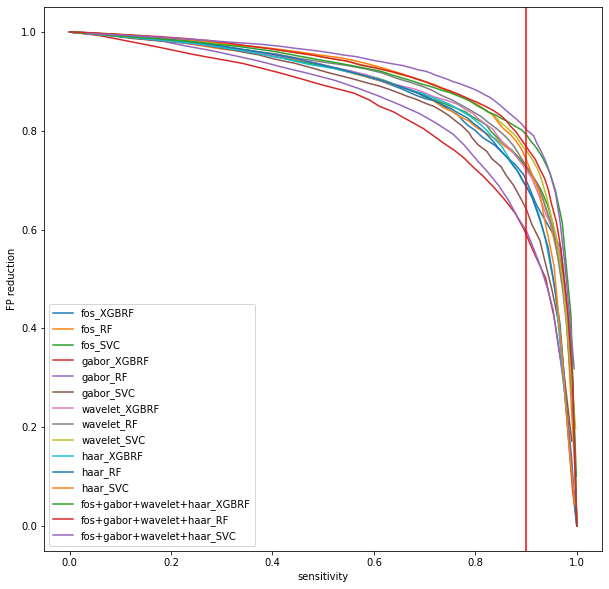

In [12]:
plt.figure(figsize=(10,10))

for fs, fs_res in results.items():
    plt.plot(fs_res[:,0], fs_res[:,1])

plt.axvline(desired_sensitivity, c='r')
plt.legend(results.keys())
plt.xlabel('sensitivity')
plt.ylabel('FP reduction')


## FROC Curve and final Metrics

In [22]:
FP2TP_rate = 10
features_set = features_sets['fos+gabor+wavelet']

In [23]:
train_img_ids = db.df[db.df.partition == 'train'].img_id.values
validation_img_ids = db.df[db.df.partition == 'validation'].img_id.values


final_clf = classifiers['SVC']# XGBRFClassifier(n_estimators=100, max_depth=8, n_jobs=-1)#

# split data into test
test_split_mask = features_data.img_id.isin(validation_img_ids)

train_fns_df = features_data_fns[~features_data_fns.img_id.isin(validation_img_ids)]
# test_df = data[data.img_id.isin(test_img_id)]
test_fns_df = features_data_fns[features_data_fns.img_id.isin(validation_img_ids)]


# split into train and take into account cleaned data with no mC in the borders of the patch
cleaned_features_data = features_data[~test_split_mask]

# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = cleaned_features_data.label
positive_train_part = cleaned_features_data[positive_mask]
negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum()) # INGORING SAMPLING

print(f'FP:TP rate: {len(negative_train_part)/len(positive_train_part)}:1')

train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)

test_df = features_data[test_split_mask]

train_y = train_df.label
test_y = test_df.label

scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_df[features_set].values)
test_X_scaled = scaler.transform(test_df[features_set].values)

final_clf.fit(train_X_scaled, train_y)

test_y_predicted = final_clf.predict_proba(test_X_scaled)[:, 1]
train_y_predicted = final_clf.predict_proba(train_X_scaled)[:, 1]

auc_test = roc_auc_score(test_y, test_y_predicted)

print(f'Auc test: {auc_test}')


FP:TP rate: 10.0:1
Auc test: 0.8993842310955872


In [40]:
test_df['confidence'] = test_y_predicted
train_df['confidence'] = train_y_predicted

train_df['labels'] = train_df['label'] 
test_df['labels'] = test_df['label'] 

/tmp/ipykernel_174272/427785115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['confidence'] = test_y_predicted
/tmp/ipykernel_174272/427785115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_df['label']


In [27]:
froc_df

x     y  radius detection_labels  pred_scores    img_id matching_gt  \
0      984  2654     6.0               TP     1.000000  20587294         2.0   
1      674   853     9.0               FP     0.063196  20587294         NaN   
2      865  1013     6.0               FP     0.094032  20587294         NaN   
3      653   831     9.0               FP     0.010021  20587294         NaN   
4      665   842     8.0               FP     0.038871  20587294         NaN   
...    ...   ...     ...              ...          ...       ...         ...   
97040  240  2494     0.0               FN     0.000000  30011484        None   
97041  245  2499     0.0               FN     0.000000  30011484        None   
97042  251  2501     0.0               FN     0.000000  30011484        None   
97043  259   249     0.0               FN     0.000000  30011484        None   
97044  639   808     5.0               FN     0.000000  30011484        None   

      repeted_idxs  pred_binary  class_labels  
0              0.0        False         False  
1              1.0        False         False  
2              2.0        False         False  
3              3.0        False         False  
4              4.0        False         False  
...            ...          ...           ...  
97040        False        False         False  
97041        False        False         False  
97042        False        False         False  
97043        False        False         False  
97044        False        False         False  

[97045 rows x 10 columns]

In [28]:
bad_forcs = froc_df.sort_values(by=['pred_scores'], ascending=False)#.head(40)
bad_forcs = bad_forcs[bad_forcs.detection_labels =='FP']
bad_forcs#[bad_forcs.img_id == 20587664].head(40)

x     y  radius detection_labels   pred_scores    img_id  \
20445   178  2307     3.0               FP  1.000000e+00  20587638   
21410   466  1515     9.0               FP  1.000000e+00  20587664   
3729   1527  1598     9.0               FP  1.000000e+00  20587320   
18044   316  2178     9.0               FP  1.000000e+00  20587638   
26315  1798  1864     7.0               FP  1.000000e+00  20587690   
...     ...   ...     ...              ...           ...       ...   
90534    10   126     4.0               FP  1.000000e-07  24065707   
90328     3   204     9.0               FP  1.000000e-07  24065707   
90329     4   151     9.0               FP  1.000000e-07  24065707   
89907     9    85     9.0               FP  1.000000e-07  24065707   
89932     7   260     7.0               FP  1.000000e-07  24065707   

      matching_gt repeted_idxs  pred_binary  class_labels  
20445         NaN       2727.0        False         False  
21410         NaN        879.0        False         False  
3729          NaN        559.0        False         False  
18044         NaN        326.0        False         False  
26315         NaN       2075.0        False         False  
...           ...          ...          ...           ...  
90534         NaN       1531.0        False         False  
90328         NaN       1325.0        False         False  
90329         NaN       1326.0        False         False  
89907         NaN        904.0        False         False  
89932         NaN        929.0        False         False  

[96418 rows x 10 columns]

In [68]:
imggg = db[16]['img']

test_img = plot_bboxes_over_image(imggg, [bad_forcs.head(40)[['x', 'y', 'radius']].values.astype(int)], [(0, 255, 0)], ['circ'])

cv2.imwrite('fff.png', test_img)

True

In [15]:
sens, avgs_fp_per_image, _ = froc_curve(froc_df, non_max_supression=True, cut_on_50fpi=True)

NameError: name 'froc_df' is not defined

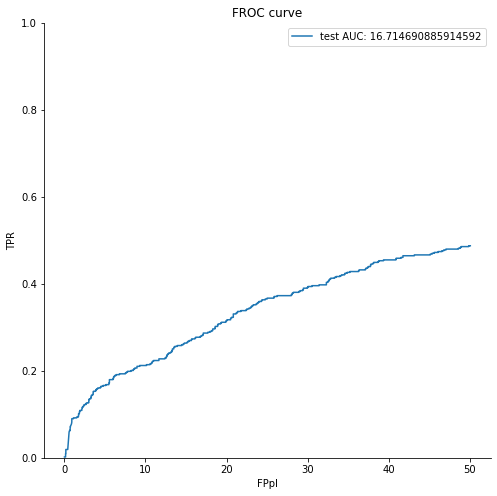

In [37]:
plot_froc(avgs_fp_per_image, sens, label='test')


/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


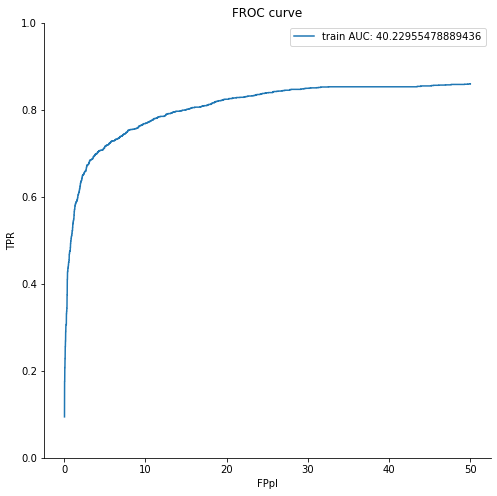

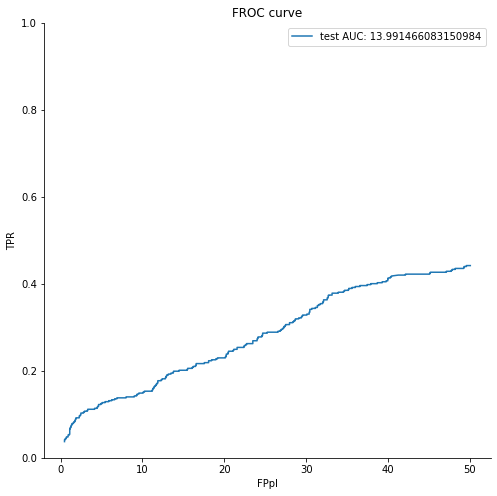

In [24]:
froc_df_train = get_froc_df_of_many_imgs_features(
    train_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    train_fns_df,
    train_y_predicted
)


sens, avgs_fp_per_image, _ = froc_curve(froc_df_train, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train')




froc_df = get_froc_df_of_many_imgs_features(
    test_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    test_fns_df,
    test_y_predicted
)

sens, avgs_fp_per_image, _ = froc_curve(froc_df, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='test')

# avg_sensitivities, std_sensitivities, avg_avgs_fp_per_image, _, _ = froc_curve_bootstrap(froc_df, n_sets=30, non_max_supression=True)
# plot_bootstrap_froc(avg_avgs_fp_per_image, avg_sensitivities, std_sensitivities)

### Problems
1. ~~Duplicates in candidates, why?~~
2. Loss of labels in masks (including origianl masks) -> 22670177_lesion_mask.png
3. ~~Not properly saved labels in INBreast db from original mask (present in original not in one from the class) -> 20587174~~
4. ~~Mask labels are not exactly in the center of the patch (even though the mC is in the center, labeled roi is shifted) ->20587466~~
5. Pectoral muscle segmentation??? Some weird lines detection -> 22670147

In [33]:
bads_df

candidate_coordinates             patch_coordinates    img_id  \
128235       [1419, 2104, 9]  ((2097, 2111), (1412, 1426))  22614150   
128241       [1430, 2107, 8]  ((2100, 2114), (1423, 1437))  22614150   
115420       [1598, 2449, 9]  ((2442, 2456), (1591, 1605))  22614097   
39610         [368, 1535, 8]    ((1528, 1542), (361, 375))  20587664   
36609         [316, 2178, 9]    ((2171, 2185), (309, 323))  20587638   
...                      ...                           ...       ...   
271389          [10, 126, 4]         ((119, 133), (3, 17))  24065707   
270762            [9, 85, 9]           ((78, 92), (2, 16))  24065707   
271183           [3, 204, 9]         ((197, 211), (0, 14))  24065707   
271184           [4, 151, 9]         ((144, 158), (0, 14))  24065707   
271758           [9, 100, 5]          ((93, 107), (2, 16))  24065707   

        repeted_idxs  matching_gt  label          conf    confidence  
128235           1.0          4.0   True  1.000000e+00  1.000000e+00  
128241           7.0          4.0   True  1.000000e+00  1.000000e+00  
115420           0.0          1.0   True  1.000000e+00  1.000000e+00  
39610          514.0          NaN  False  1.000000e+00  1.000000e+00  
36609          326.0          NaN  False  1.000000e+00  1.000000e+00  
...              ...          ...    ...           ...           ...  
271389        1531.0          NaN  False  1.000000e-07  1.000000e-07  
270762         904.0          NaN  False  1.000000e-07  1.000000e-07  
271183        1325.0          NaN  False  1.000000e-07  1.000000e-07  
271184        1326.0          NaN  False  1.000000e-07  1.000000e-07  
271758        1900.0          NaN  False  1.000000e-07  1.000000e-07  

[96932 rows x 8 columns]

In [34]:
bads_df = pd.concat([test_df]).sort_values(by=['confidence'], ascending=False).drop(columns=features_set)
bads_df = bads_df[~bads_df.label]
bads_df

candidate_coordinates             patch_coordinates    img_id  \
39610         [368, 1535, 8]    ((1528, 1542), (361, 375))  20587664   
36609         [316, 2178, 9]    ((2171, 2185), (309, 323))  20587638   
39975         [466, 1515, 9]    ((1508, 1522), (459, 473))  20587664   
36930          [20, 2415, 9]      ((2408, 2422), (13, 27))  20587638   
41423        [1797, 1870, 4]  ((1863, 1877), (1790, 1804))  20587664   
...                      ...                           ...       ...   
271389          [10, 126, 4]         ((119, 133), (3, 17))  24065707   
270762            [9, 85, 9]           ((78, 92), (2, 16))  24065707   
271183           [3, 204, 9]         ((197, 211), (0, 14))  24065707   
271184           [4, 151, 9]         ((144, 158), (0, 14))  24065707   
271758           [9, 100, 5]          ((93, 107), (2, 16))  24065707   

        repeted_idxs  matching_gt  label          conf    confidence  
39610          514.0          NaN  False  1.000000e+00  1.000000e+00  
36609          326.0          NaN  False  1.000000e+00  1.000000e+00  
39975          879.0          NaN  False  1.000000e+00  1.000000e+00  
36930          647.0          NaN  False  1.000000e+00  1.000000e+00  
41423         2327.0          NaN  False  1.000000e+00  1.000000e+00  
...              ...          ...    ...           ...           ...  
271389        1531.0          NaN  False  1.000000e-07  1.000000e-07  
270762         904.0          NaN  False  1.000000e-07  1.000000e-07  
271183        1325.0          NaN  False  1.000000e-07  1.000000e-07  
271184        1326.0          NaN  False  1.000000e-07  1.000000e-07  
271758        1900.0          NaN  False  1.000000e-07  1.000000e-07  

[96418 rows x 8 columns]

<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


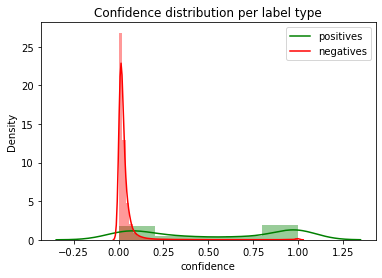

<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


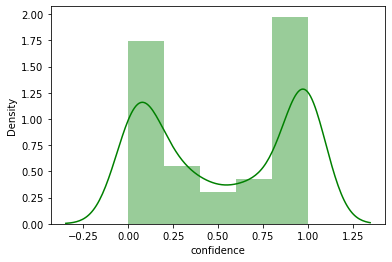

<IPython.core.display.Javascript object>

/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


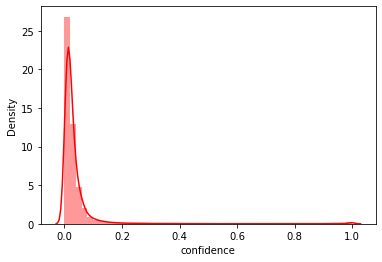

In [42]:
sns.distplot(test_df[test_df.labels].confidence, color='g')
sns.distplot(test_df[~test_df.labels].confidence, color='r')
plt.legend(['positives', 'negatives'])
plt.title('Confidence distribution per label type')
plt.show()

sns.distplot(test_df[test_df.labels].confidence, color='g')
plt.show()

sns.distplot(test_df[~test_df.labels].confidence, color='r')
plt.show()


  3%|▎         | 3/100 [00:06<03:30,  2.17s/it]/tmp/ipykernel_174272/2104082210.py:13: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
/tmp/ipykernel_174272/2104082210.py:17: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], cmap='gray', vmin=0)
/tmp/ipykernel_174272/2104082210.py:21: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0, cmap='gray', vmin=0)
 20%|██        | 20/100 [00:42<02:52,  2.16s/it]/tmp/ipykernel_174272/2104082210.py:10: RuntimeWarning: More than 20 figures have been opened. Figures crea

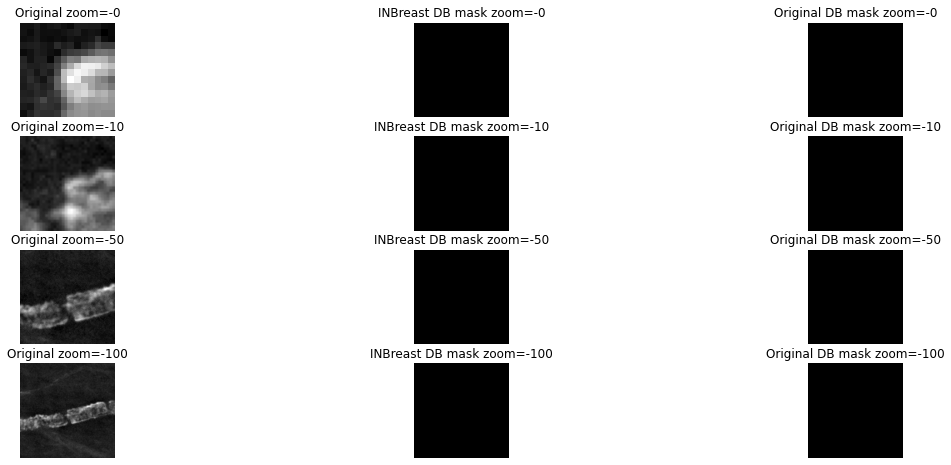

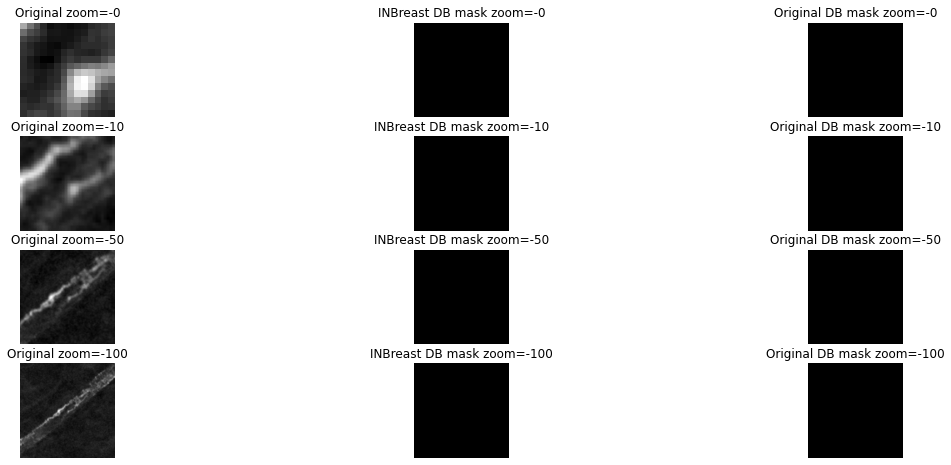

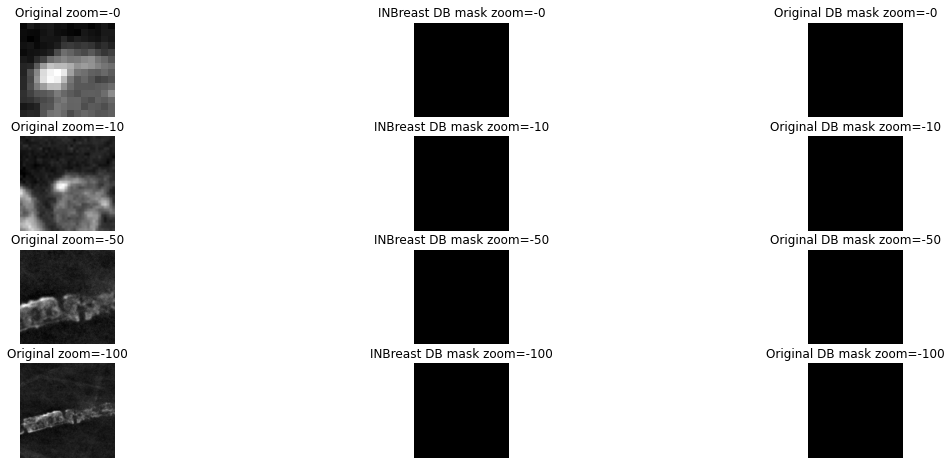

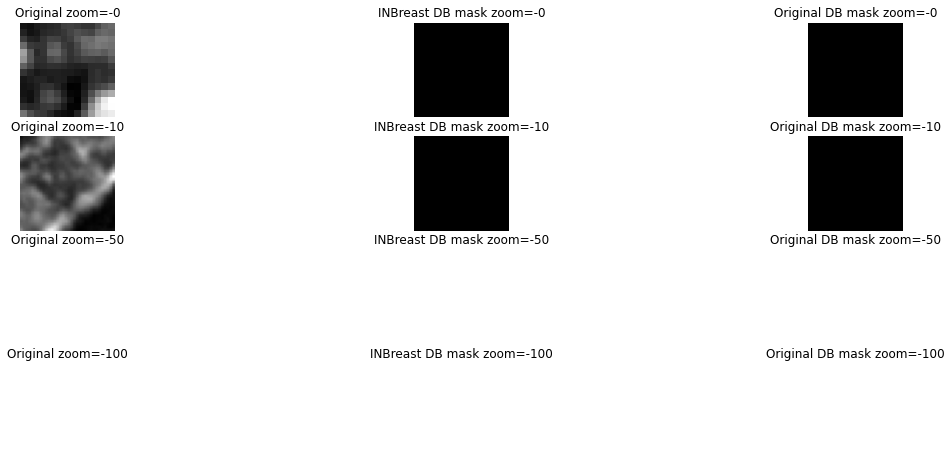

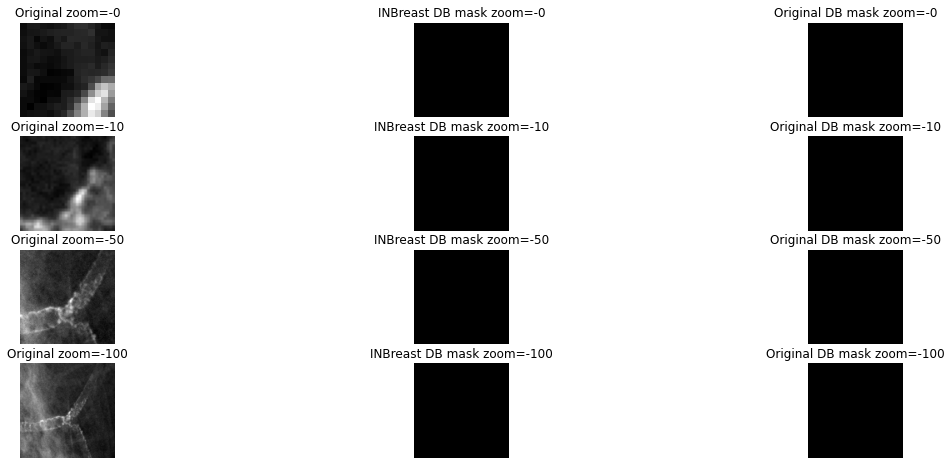

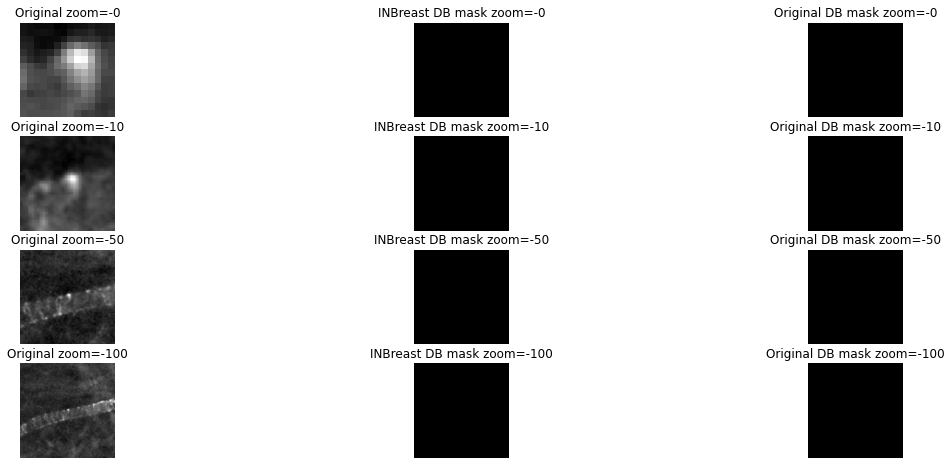

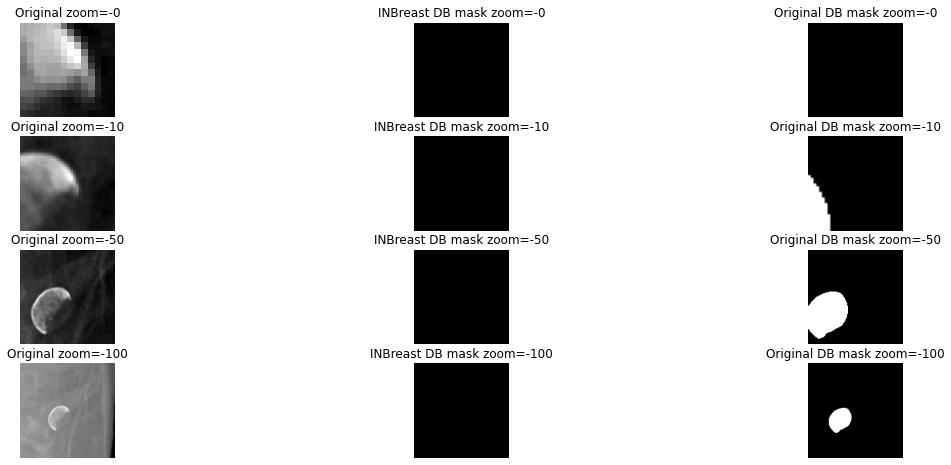

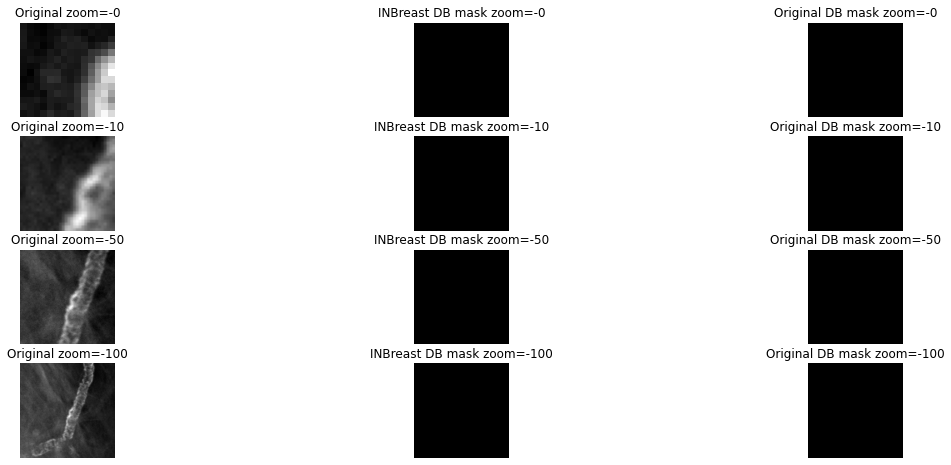

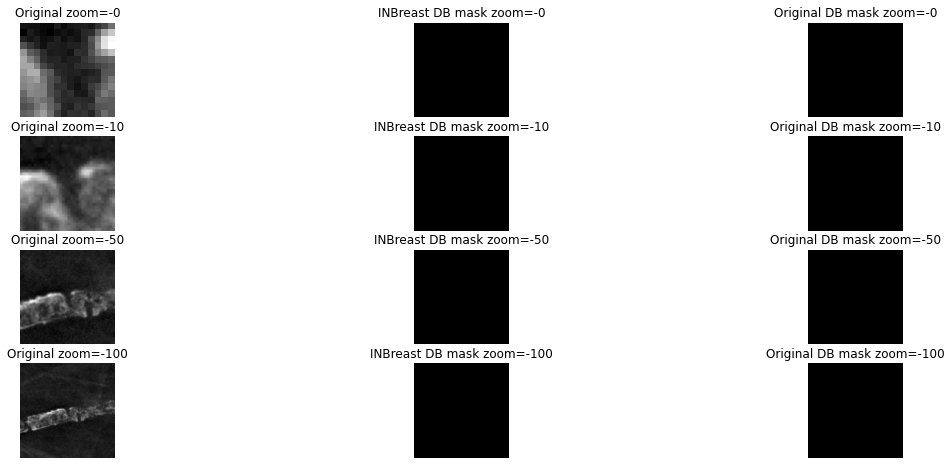

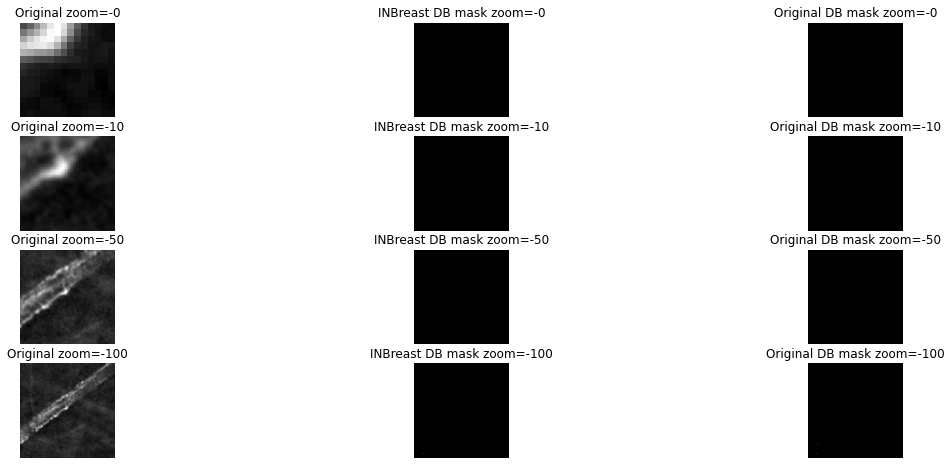

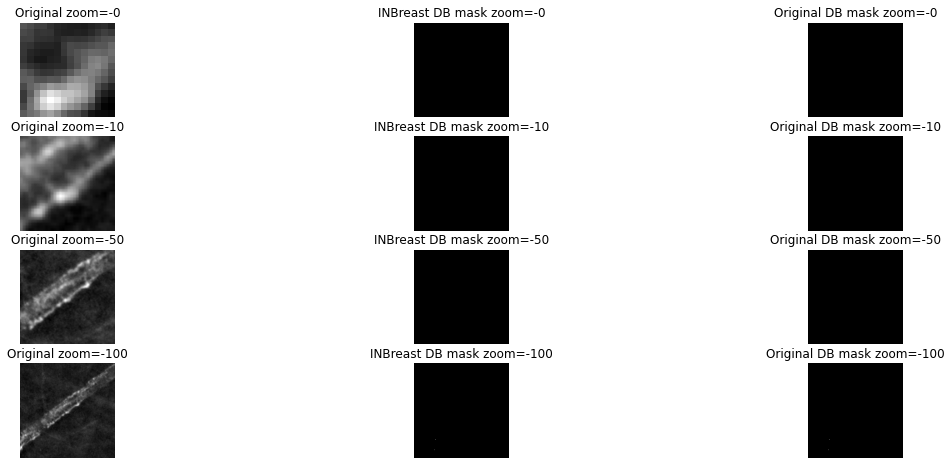

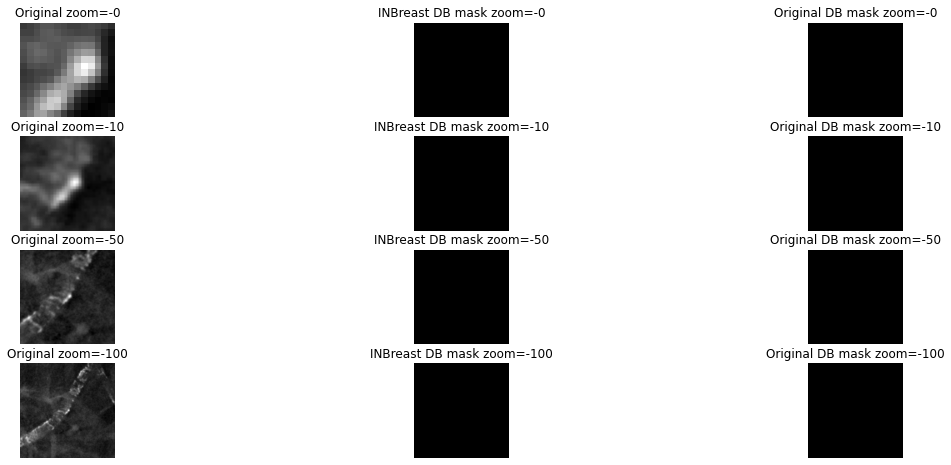

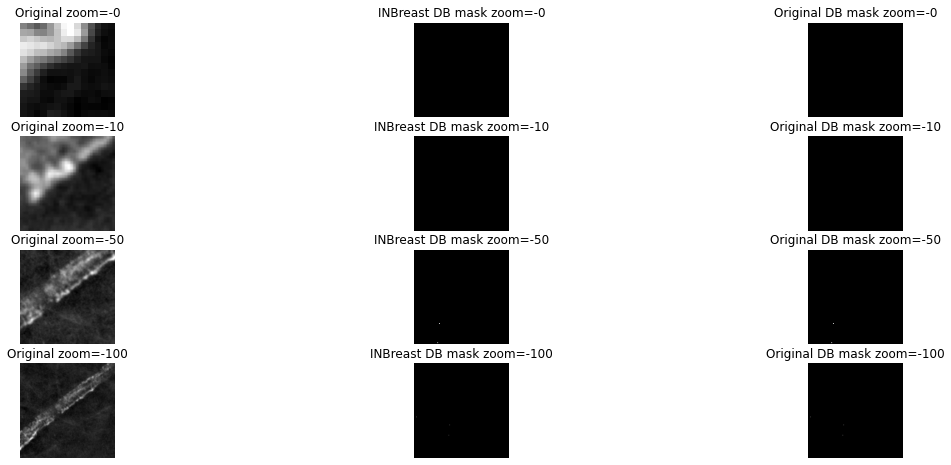

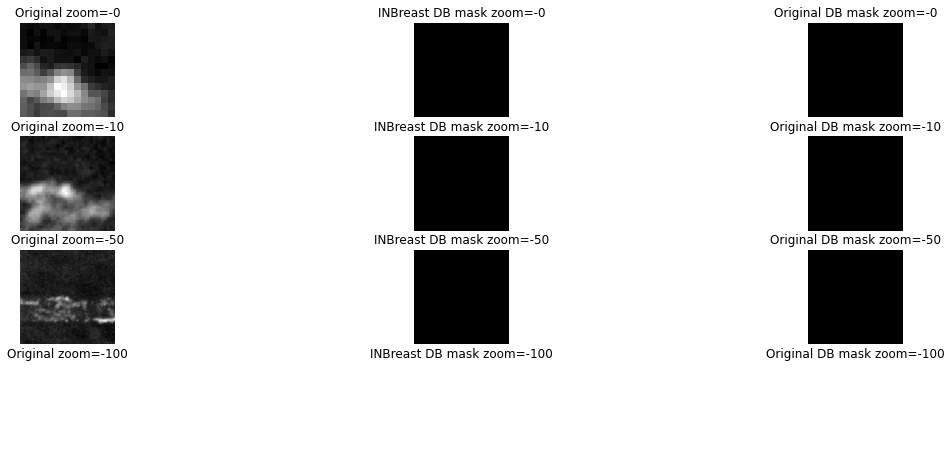

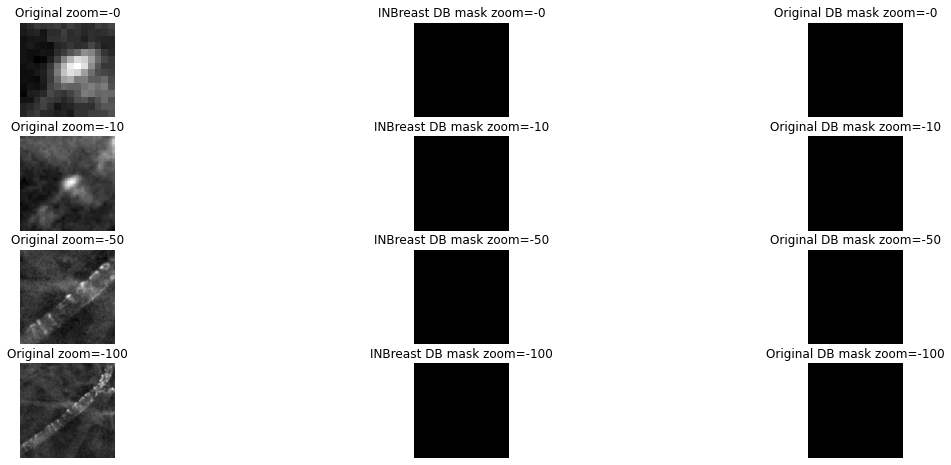

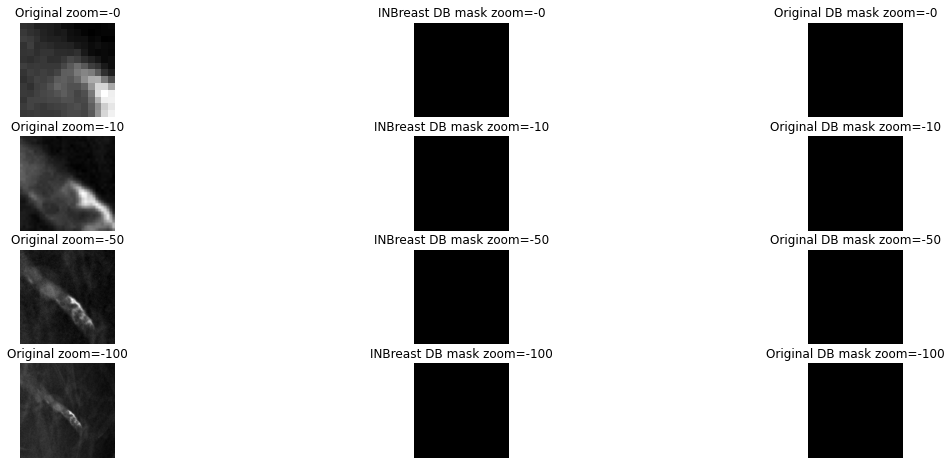

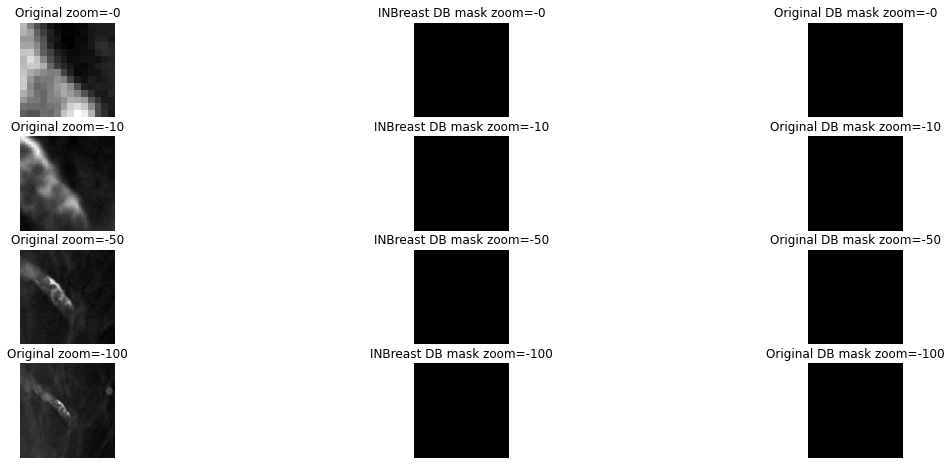

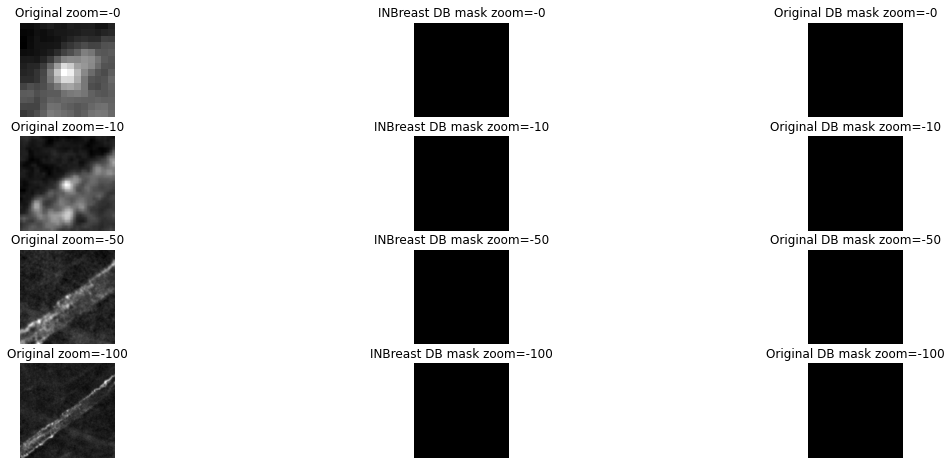

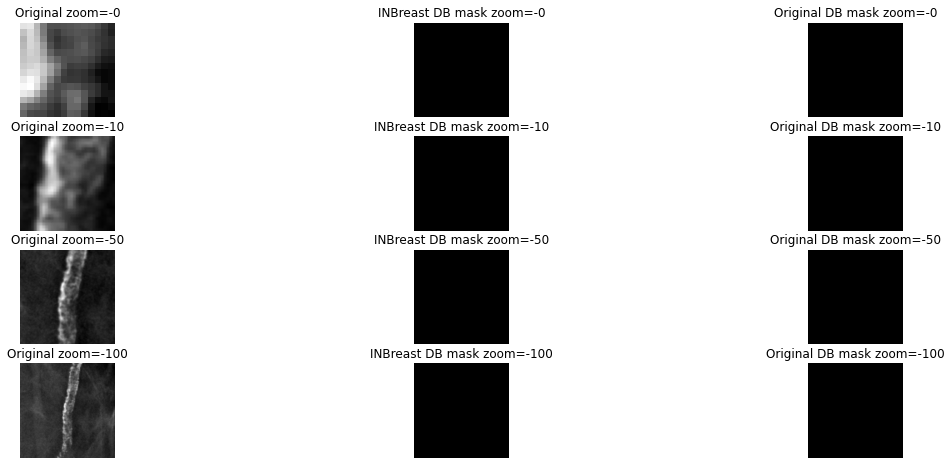

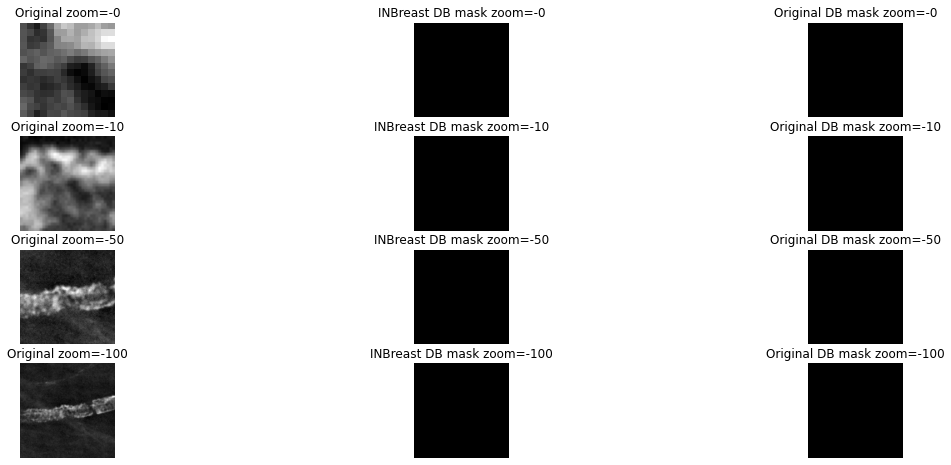

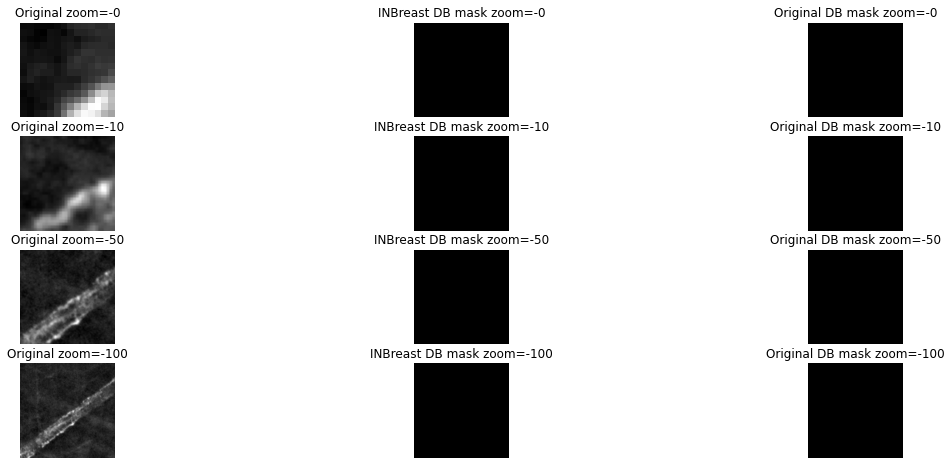

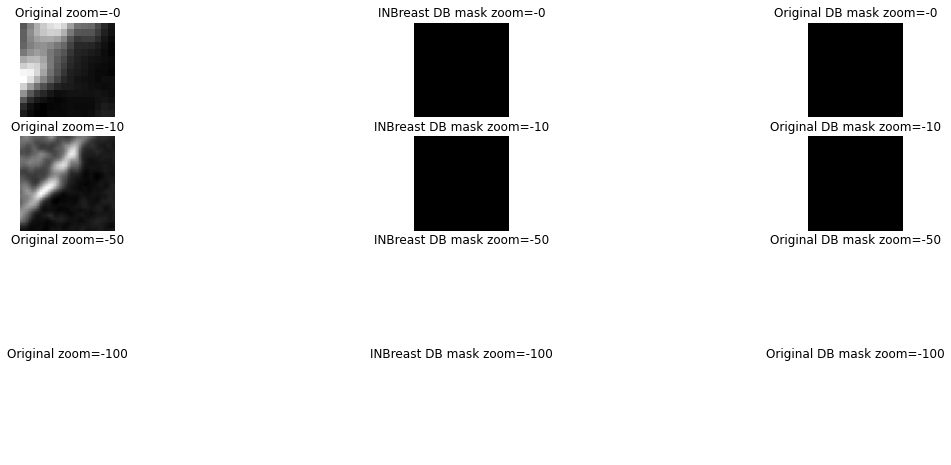

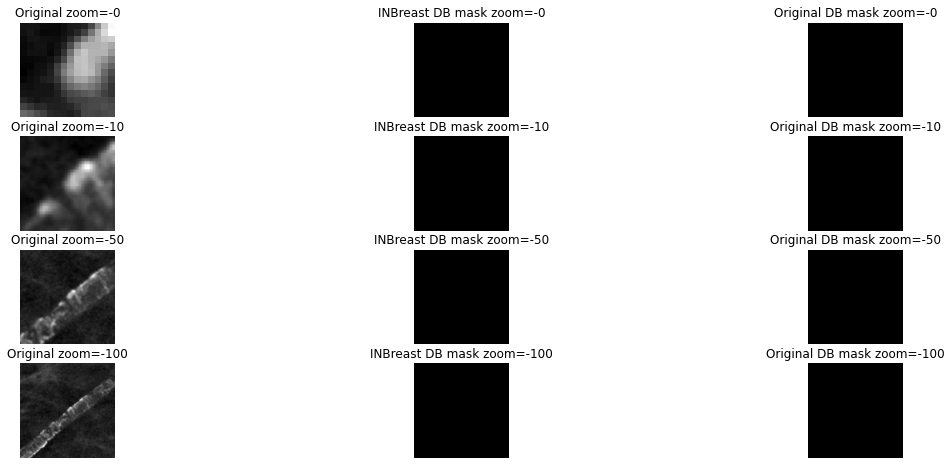

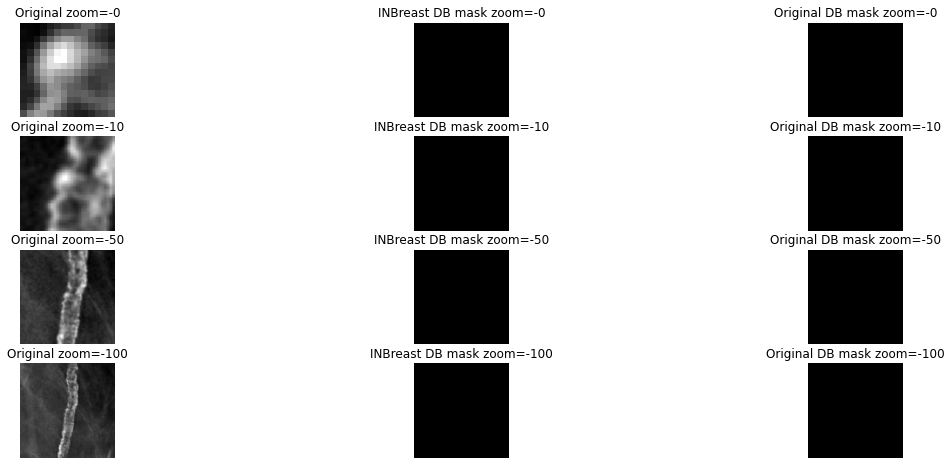

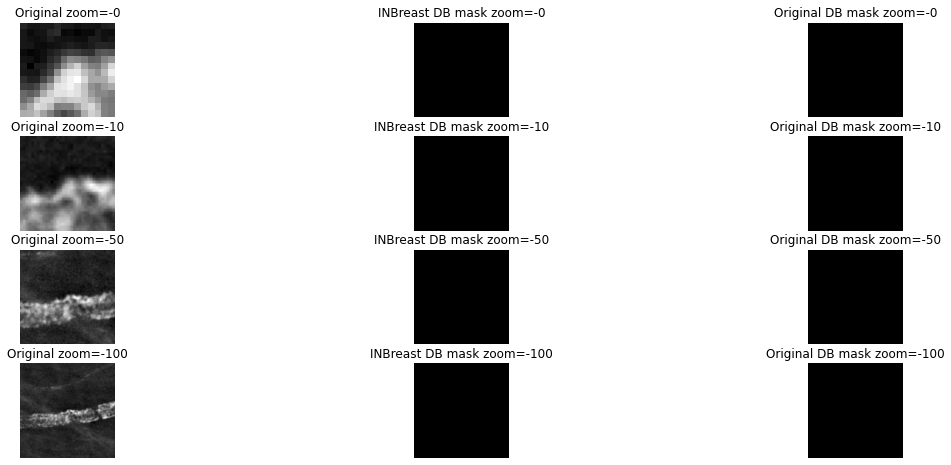

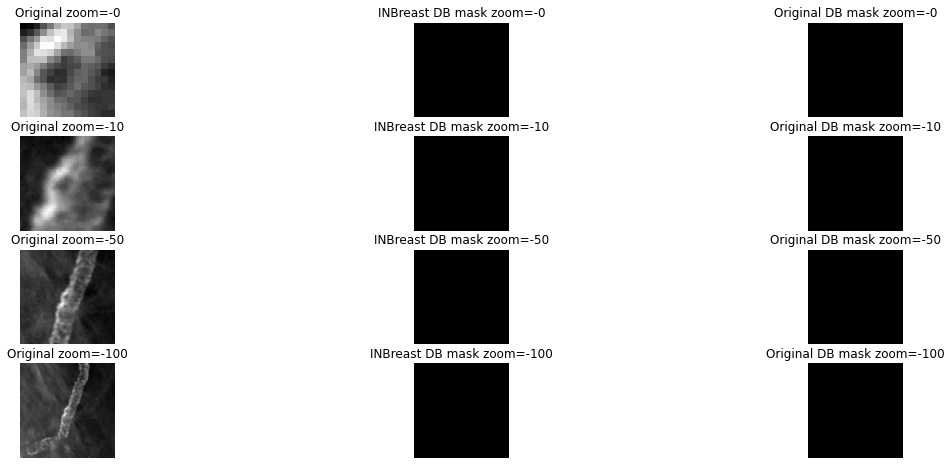

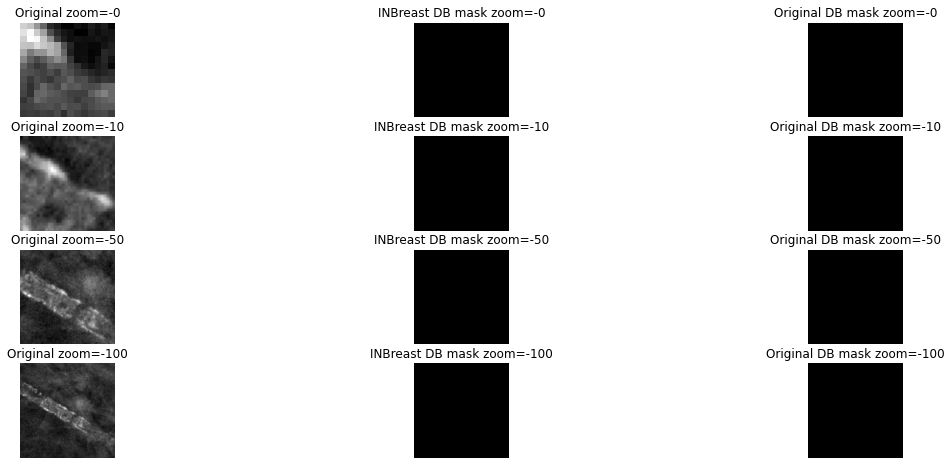

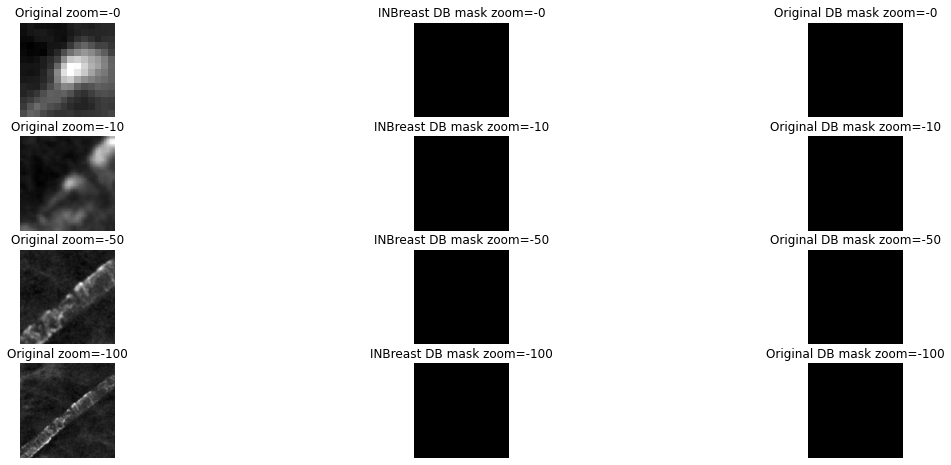

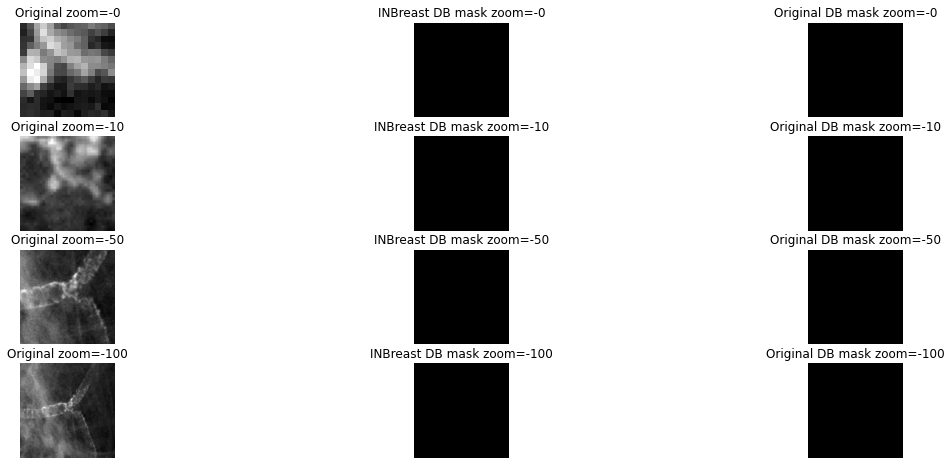

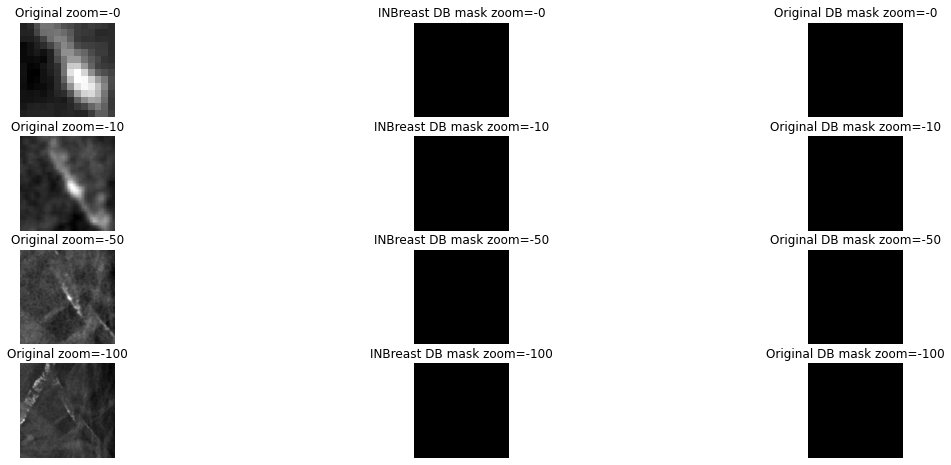

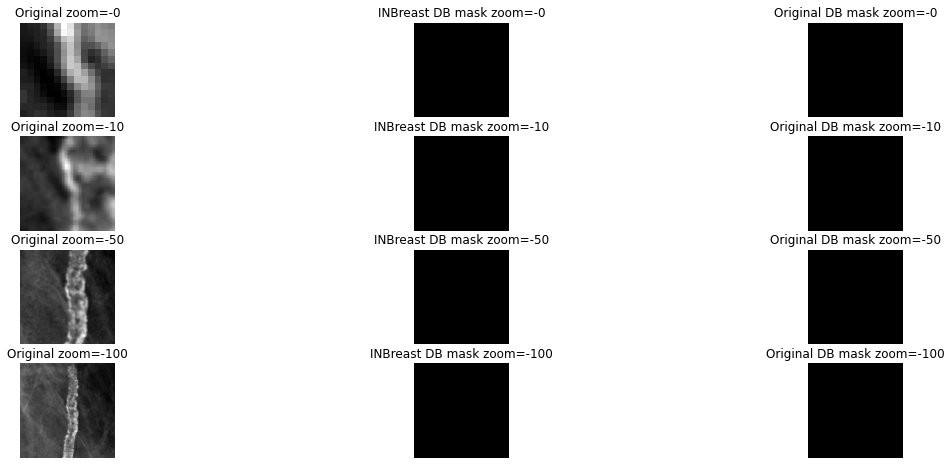

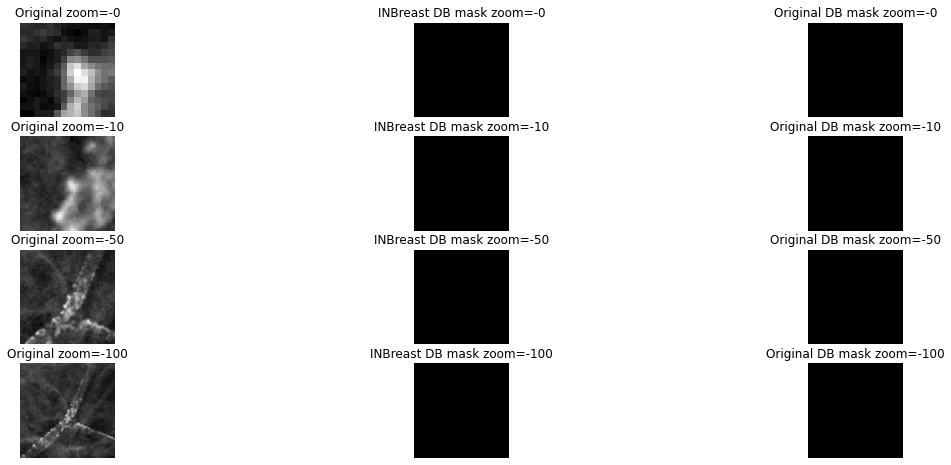

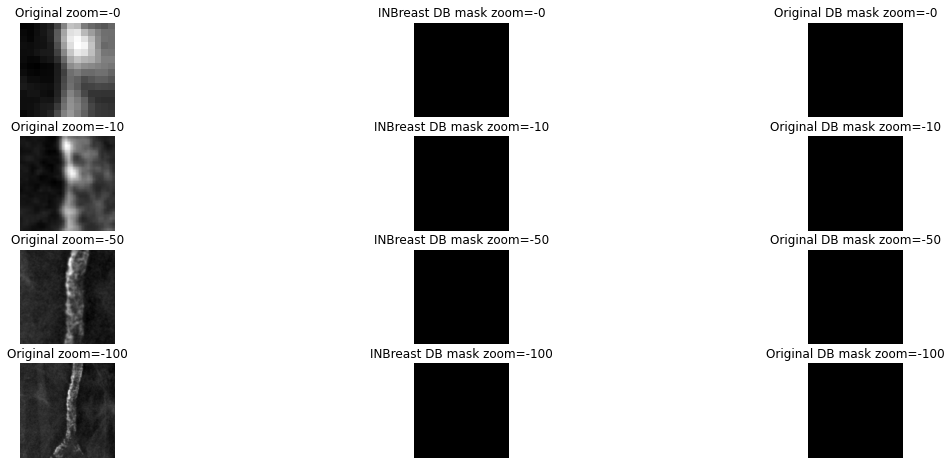

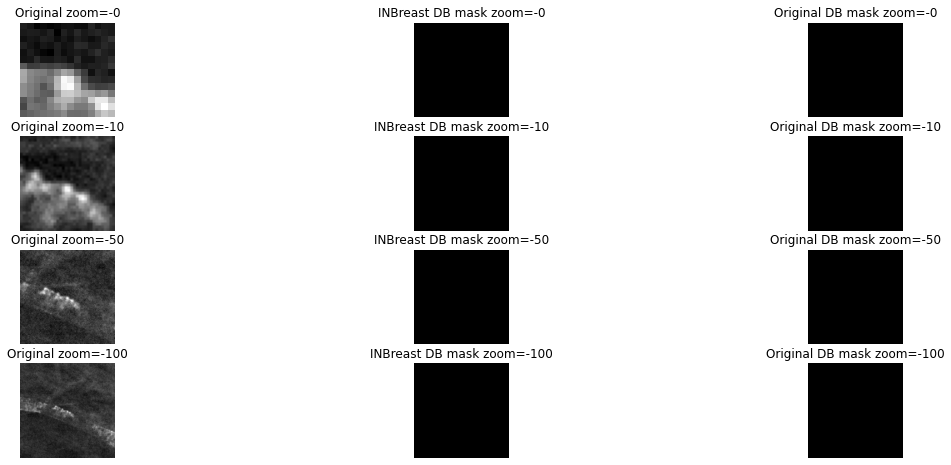

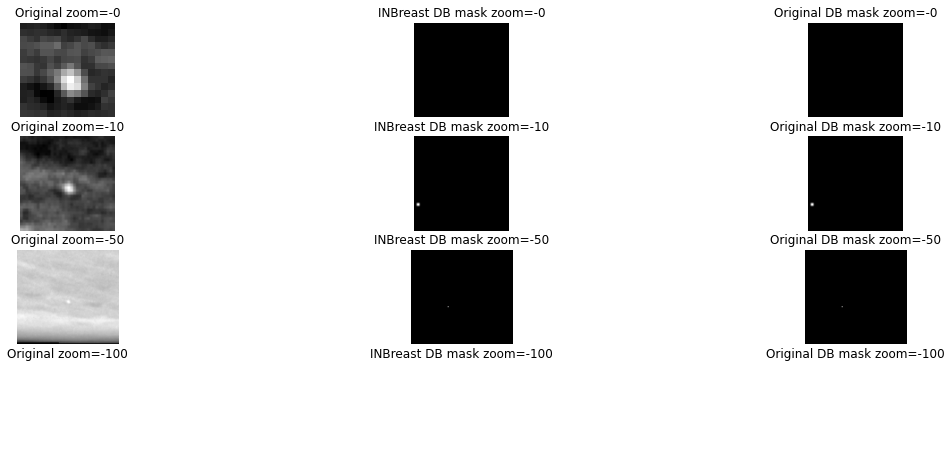

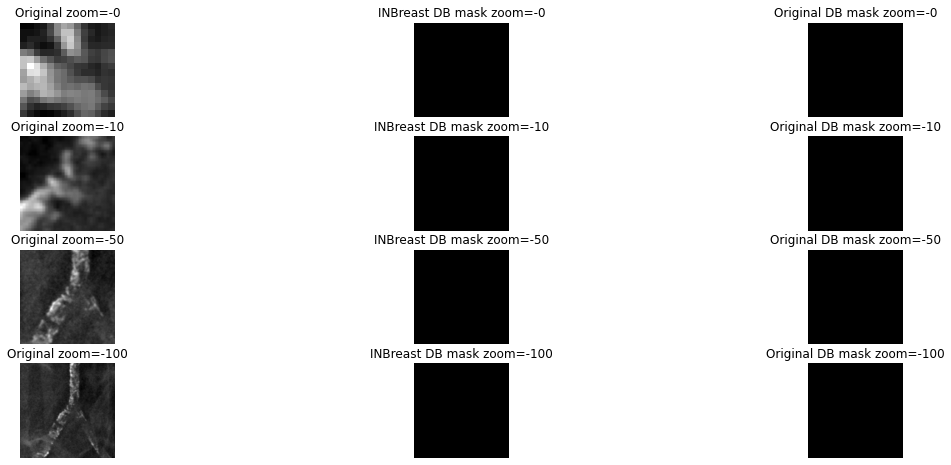

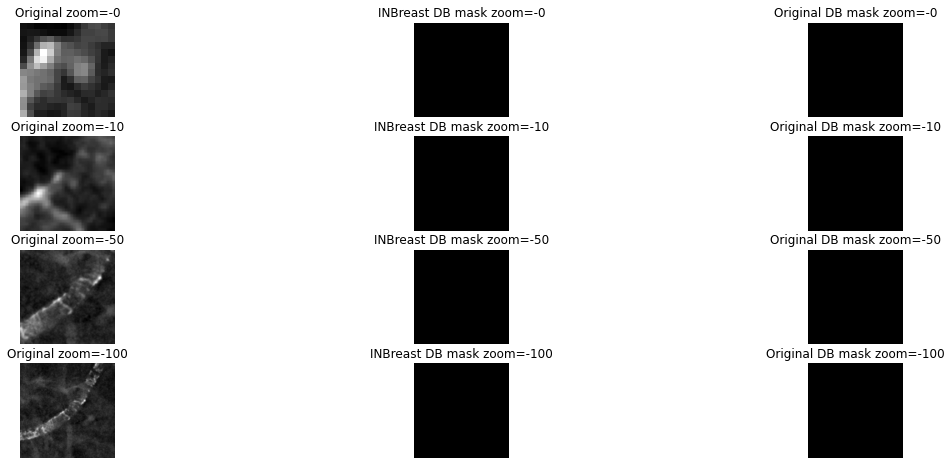

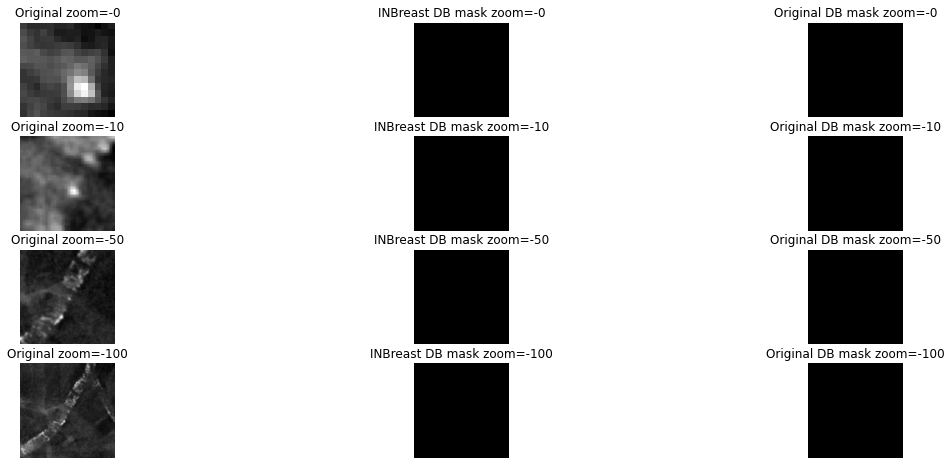

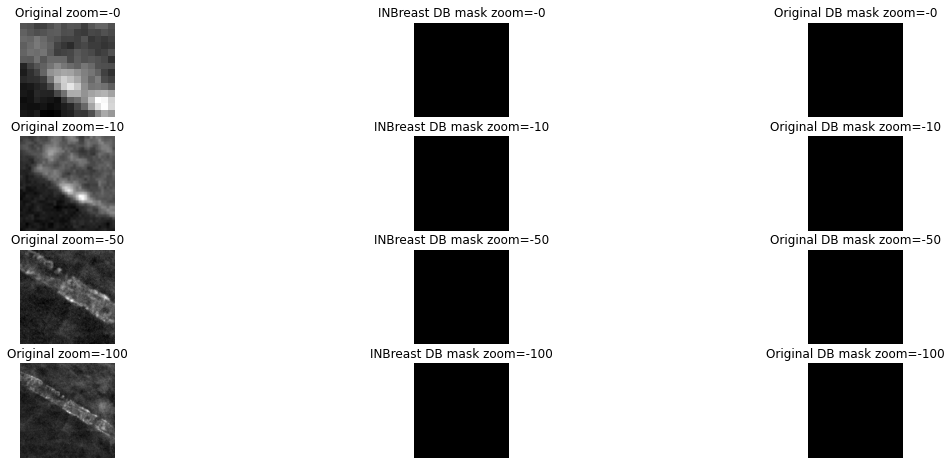

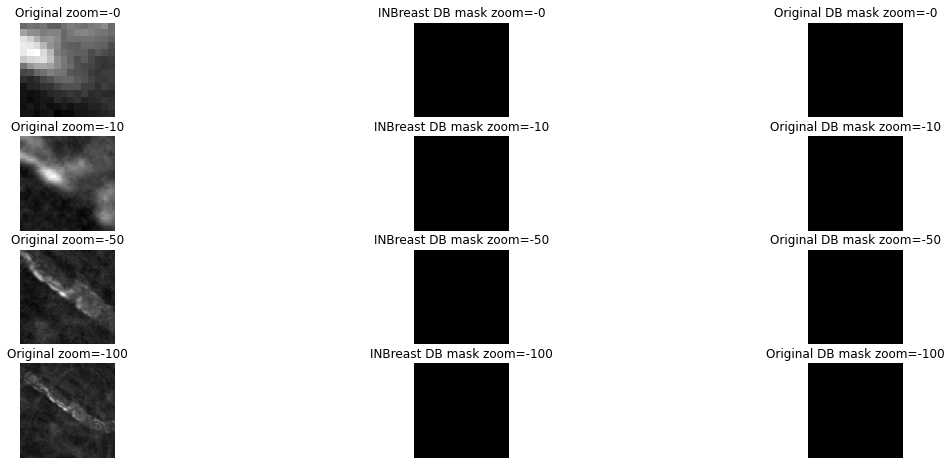

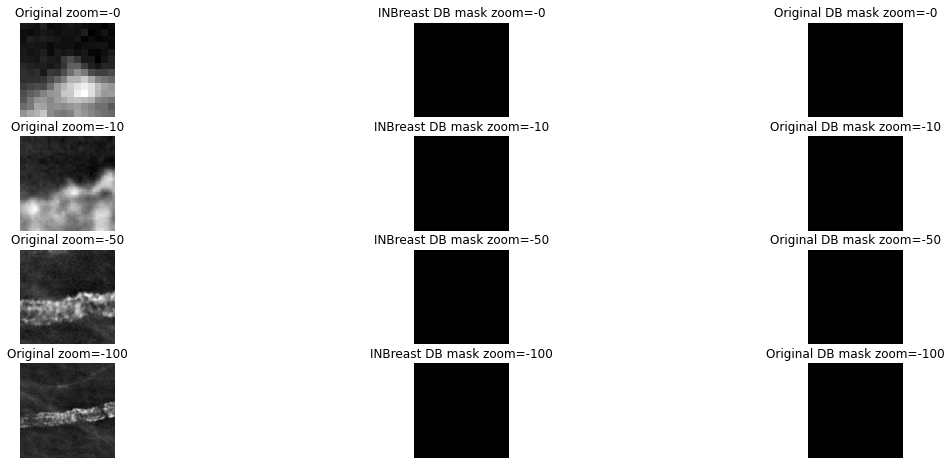

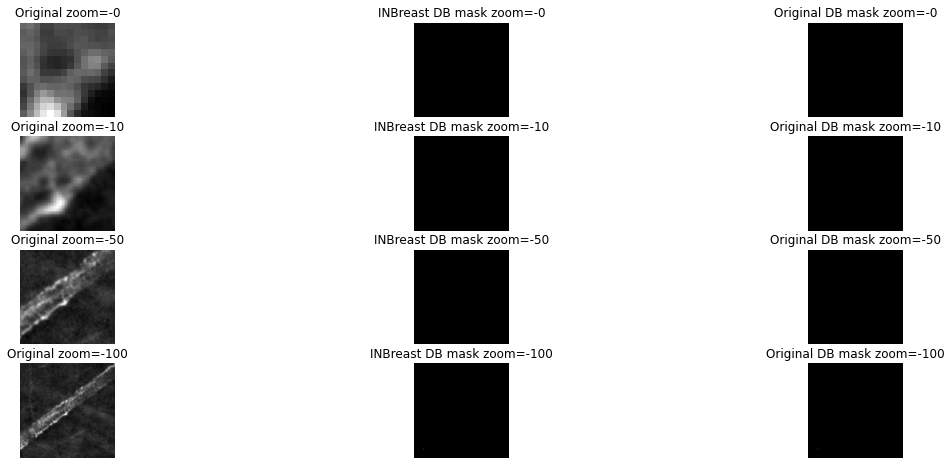

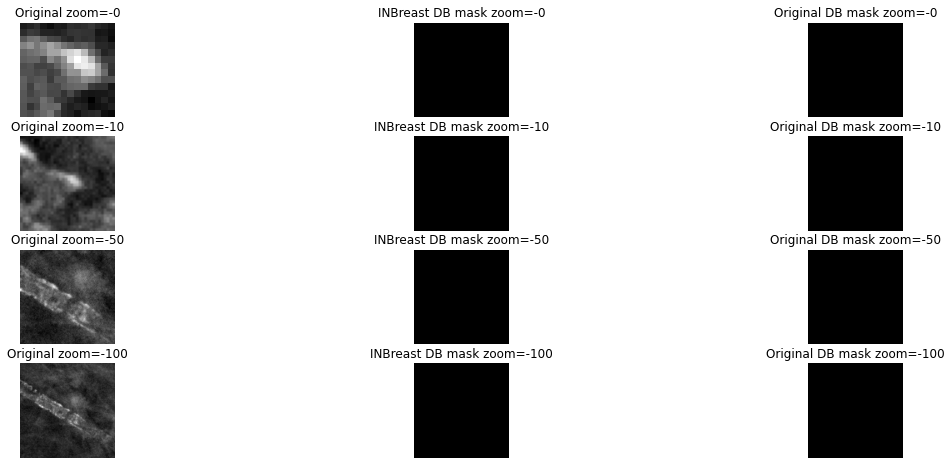

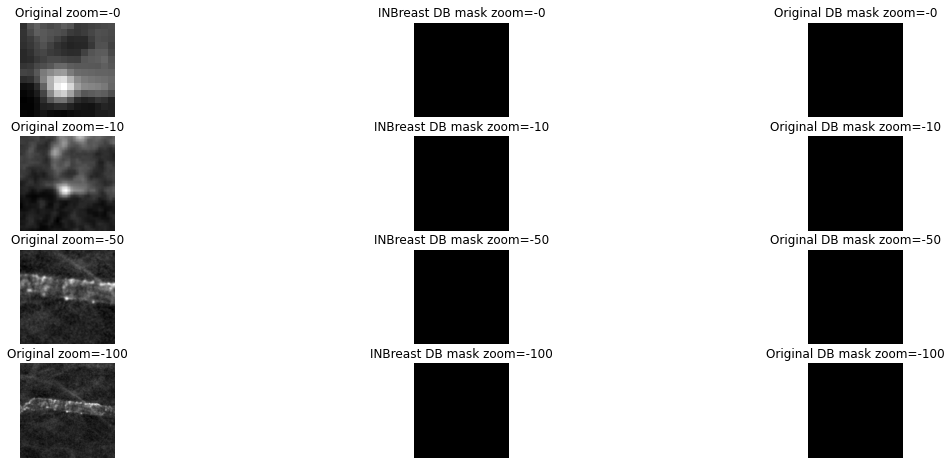

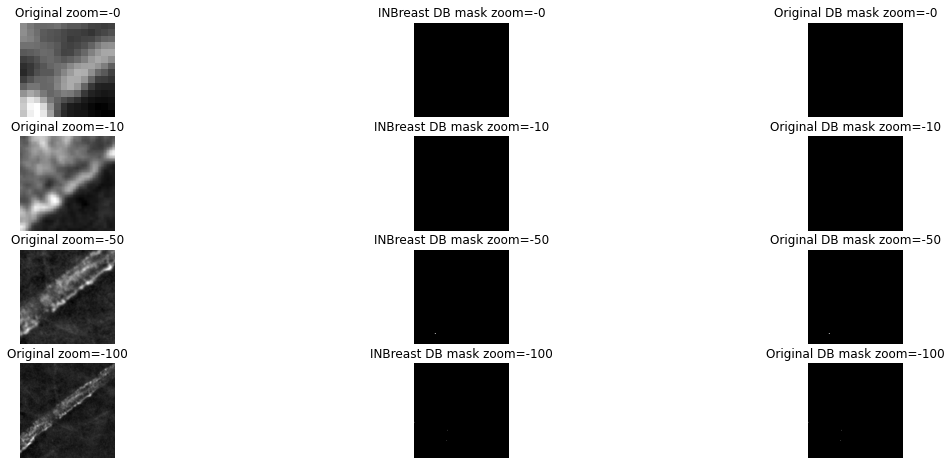

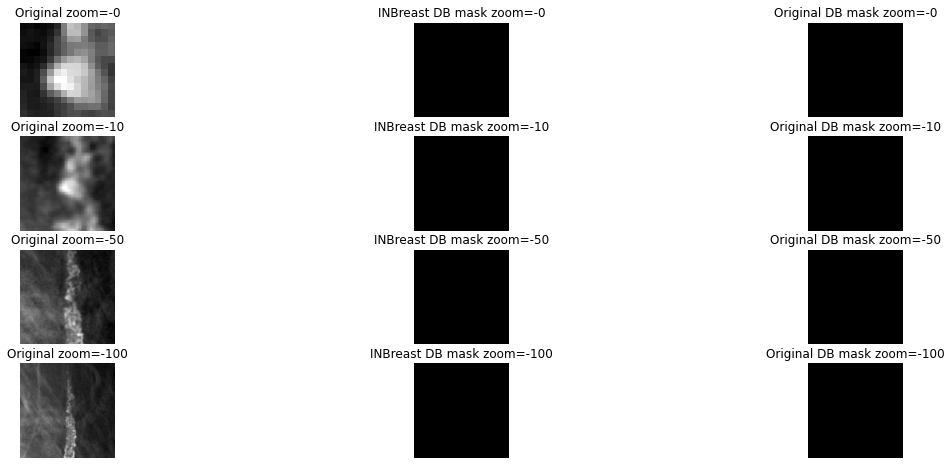

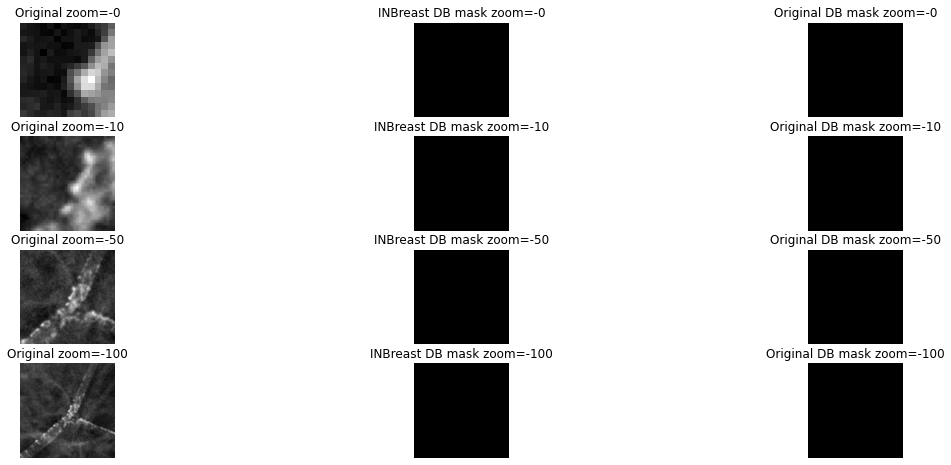

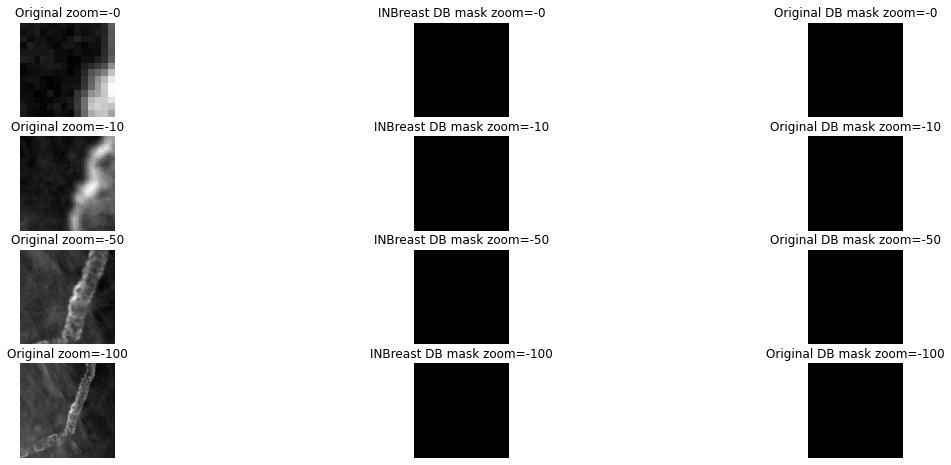

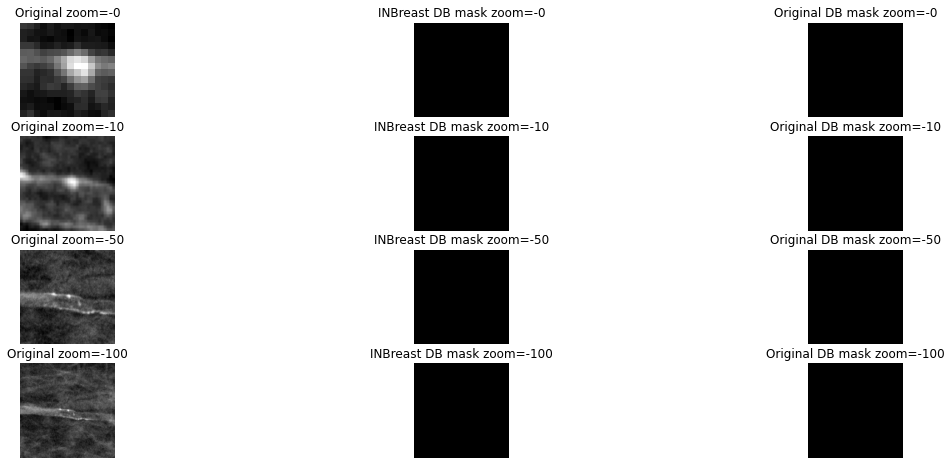

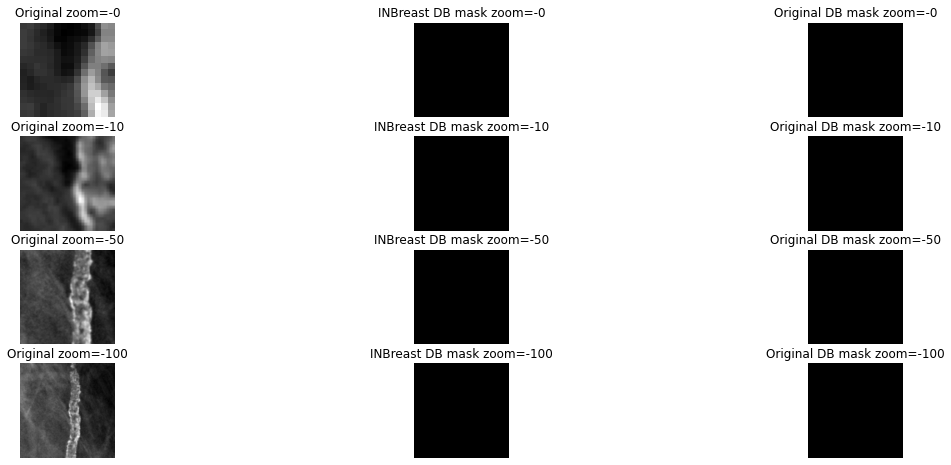

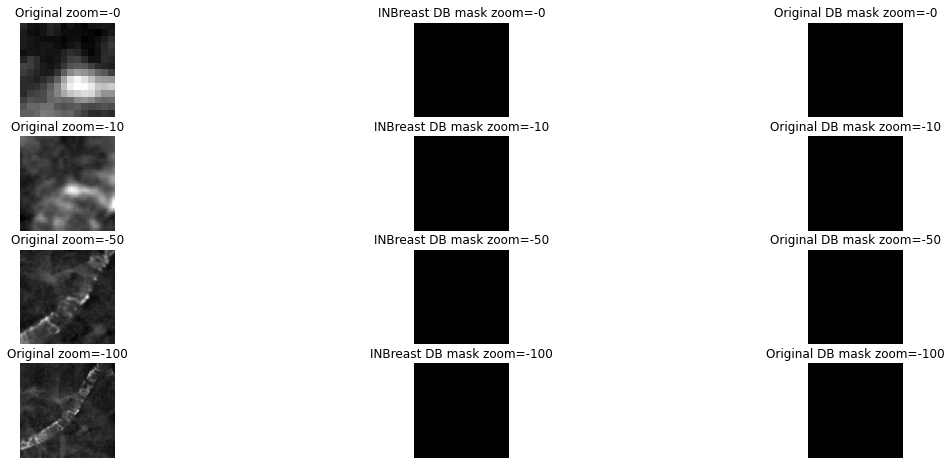

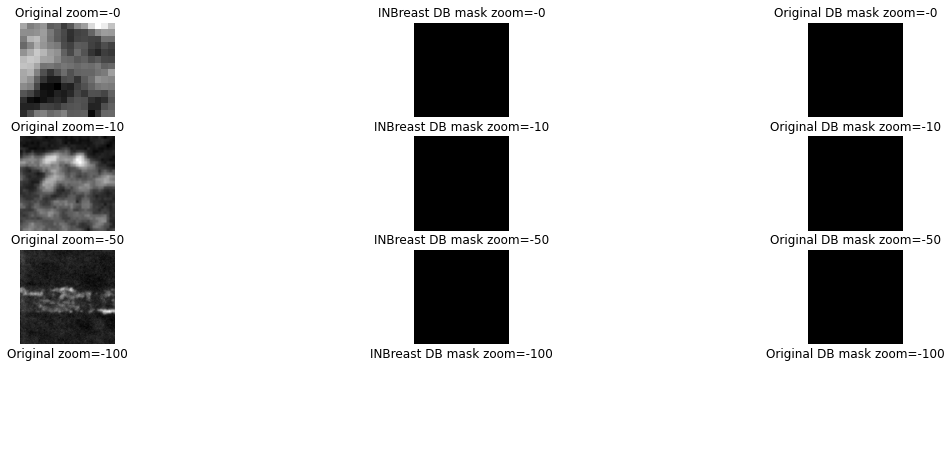

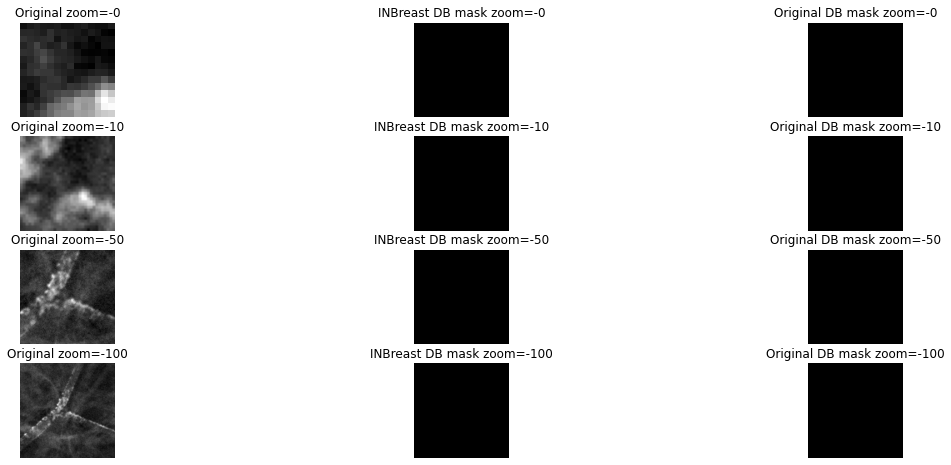

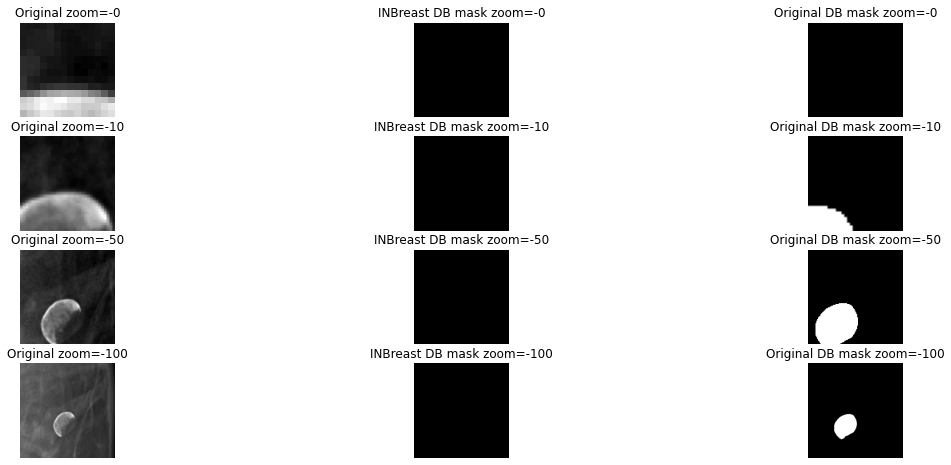

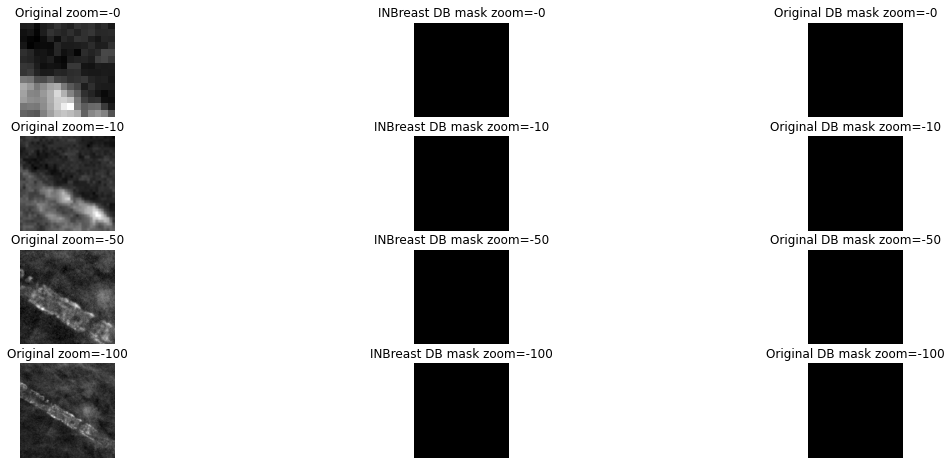

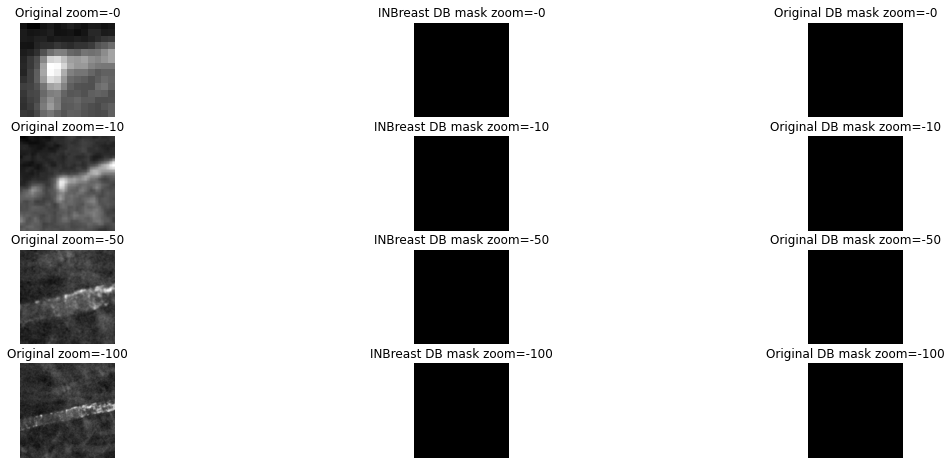

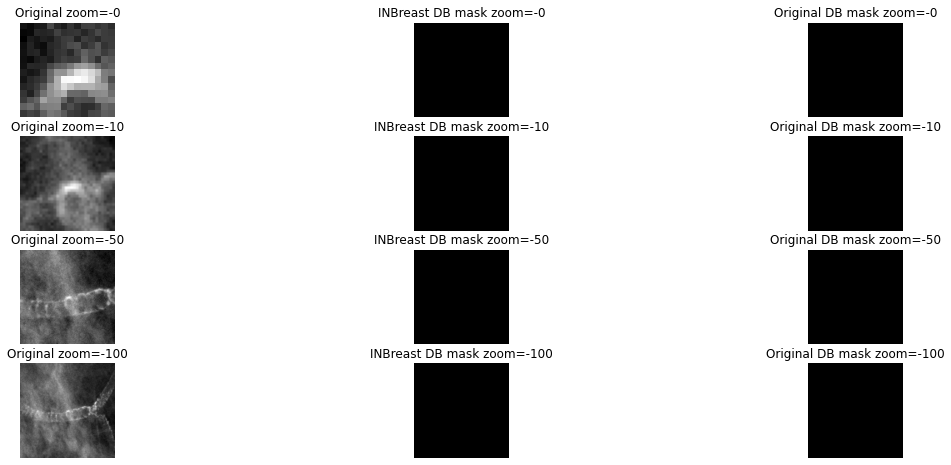

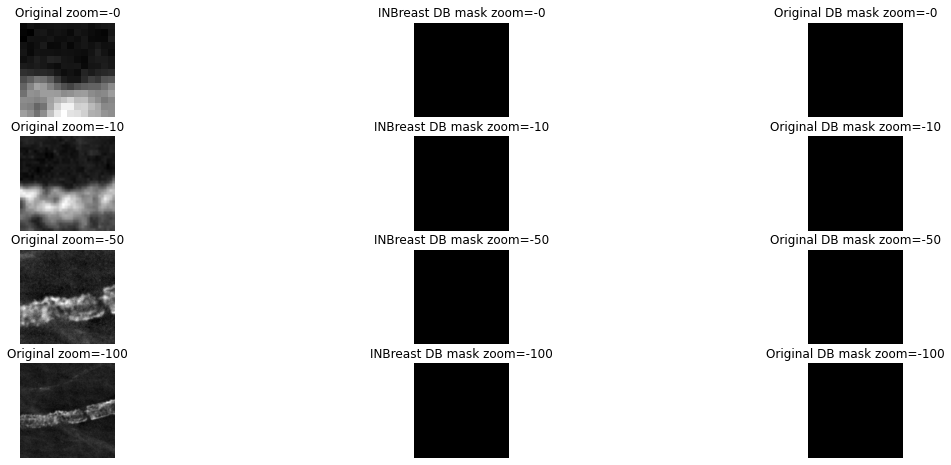

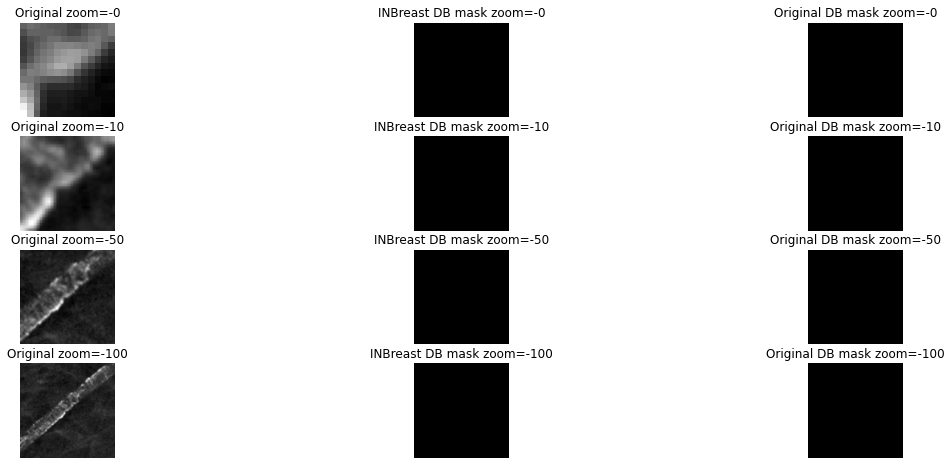

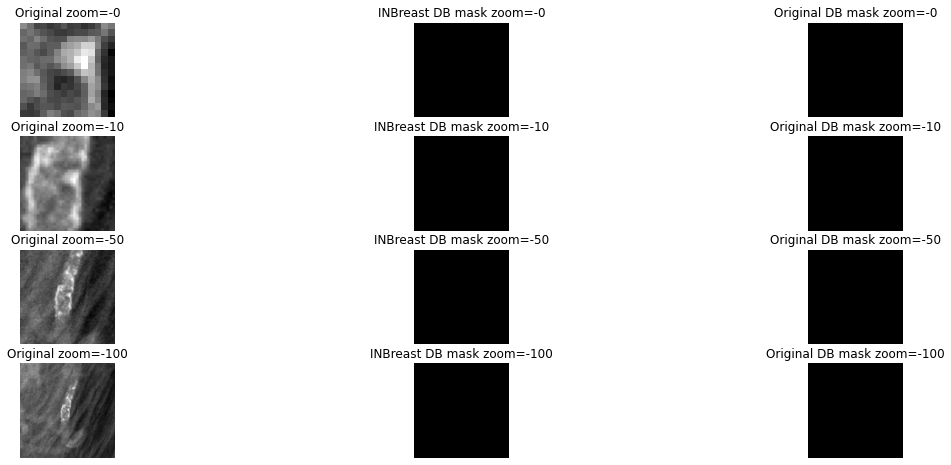

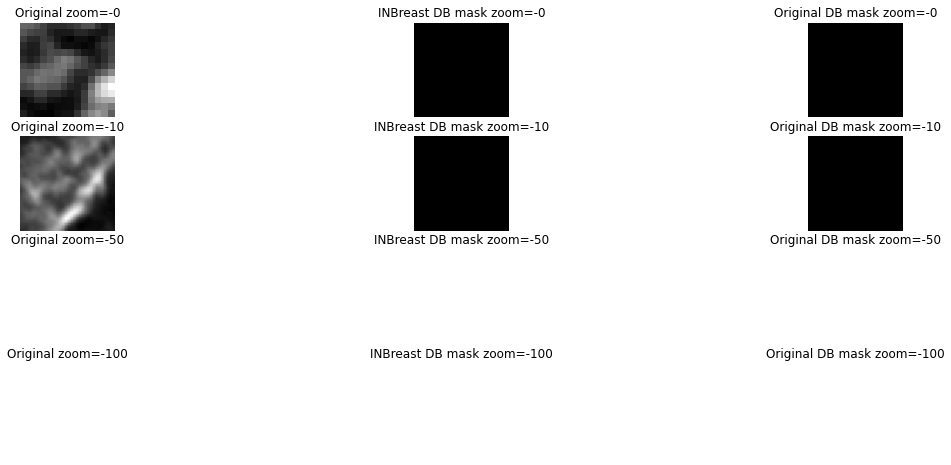

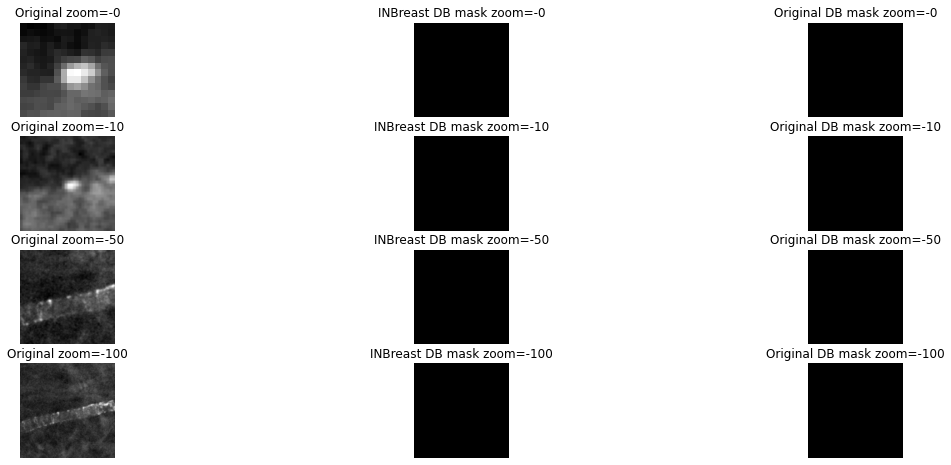

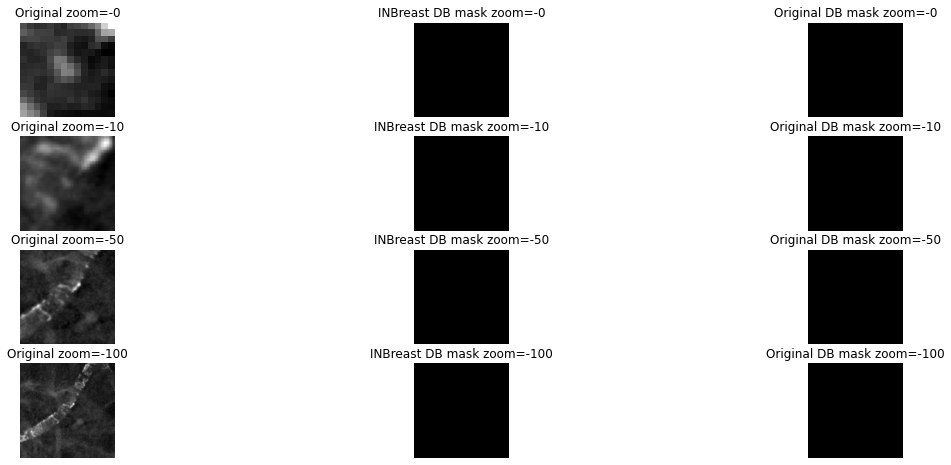

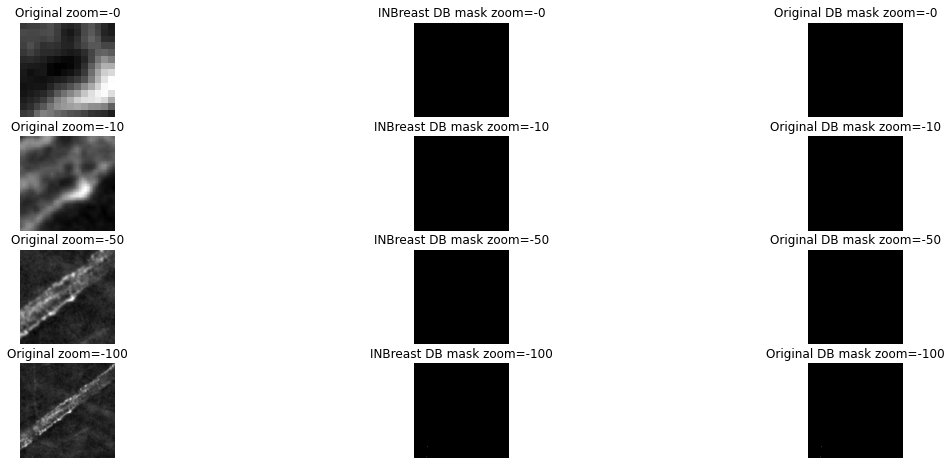

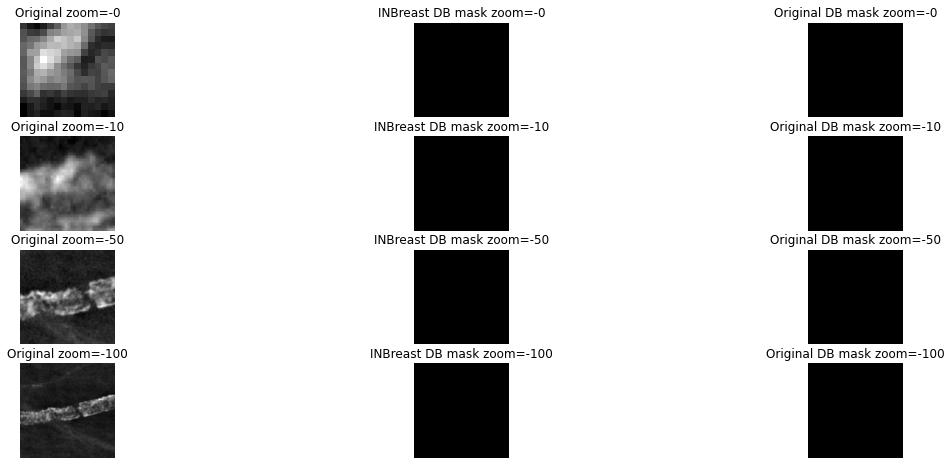

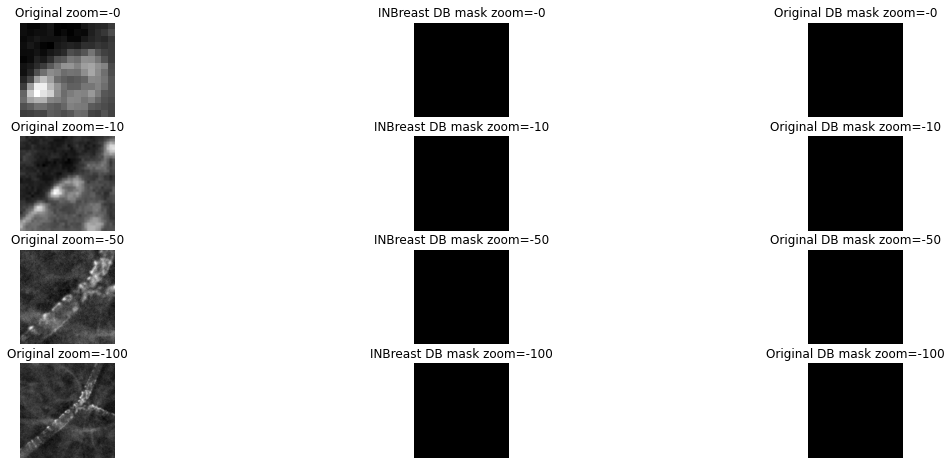

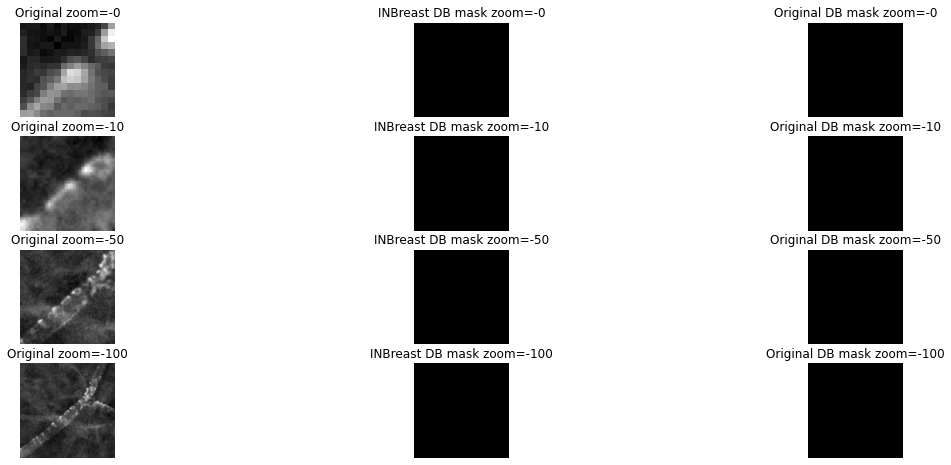

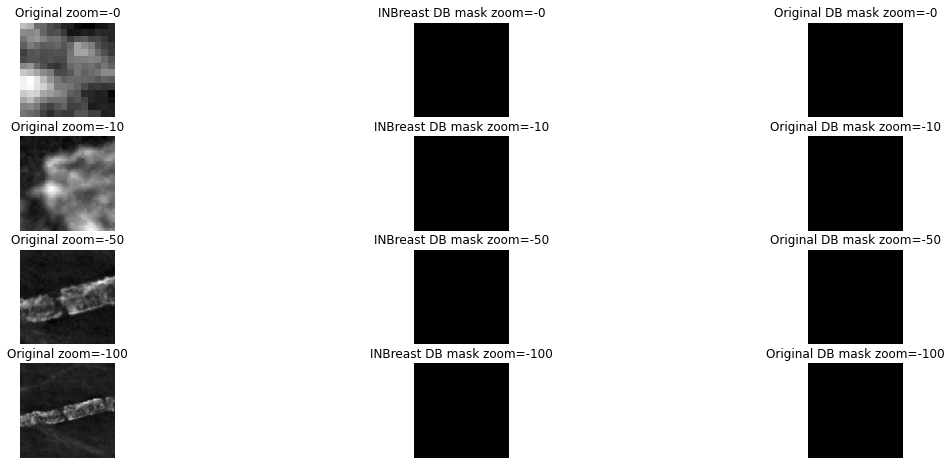

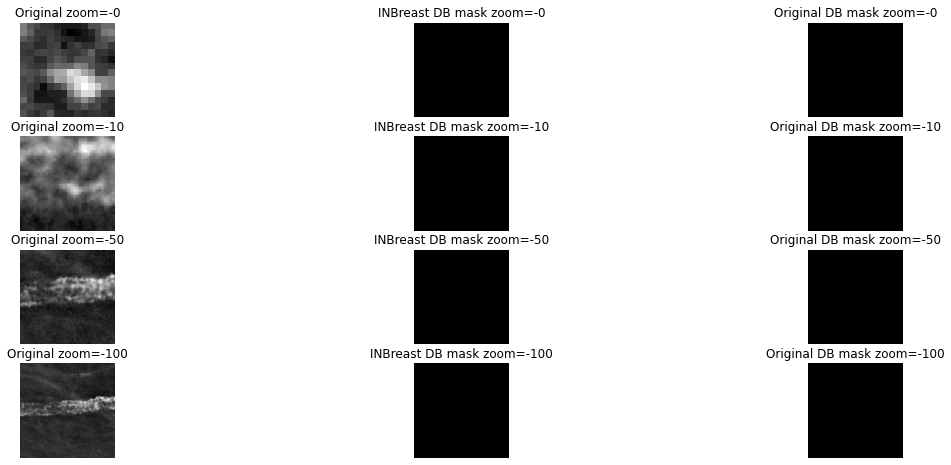

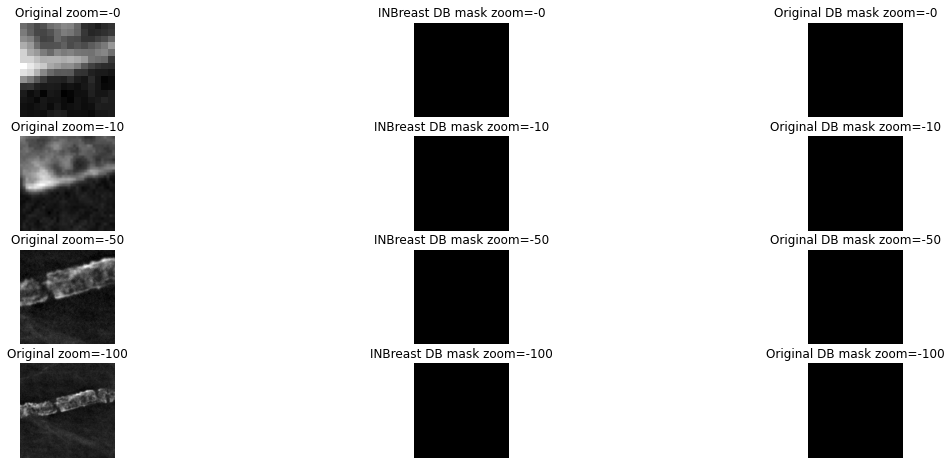

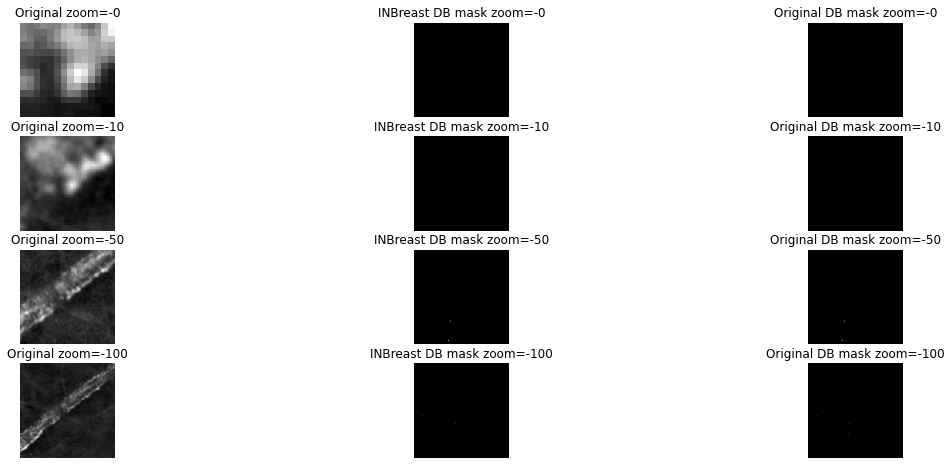

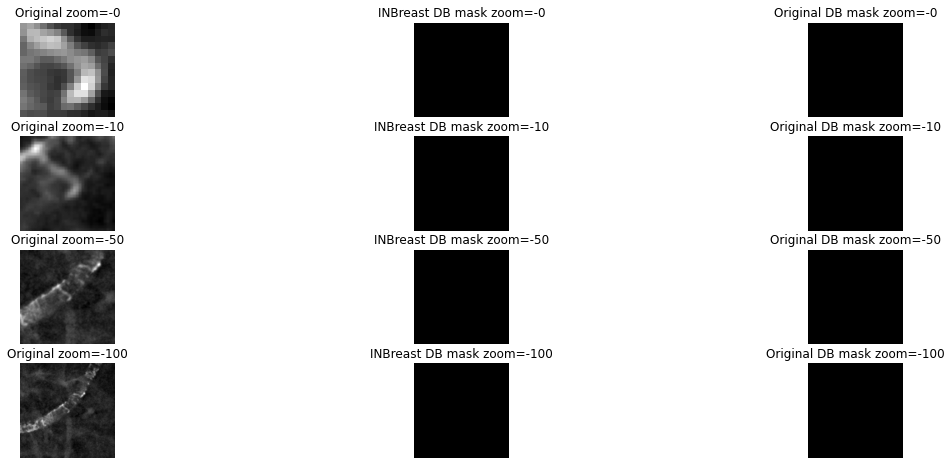

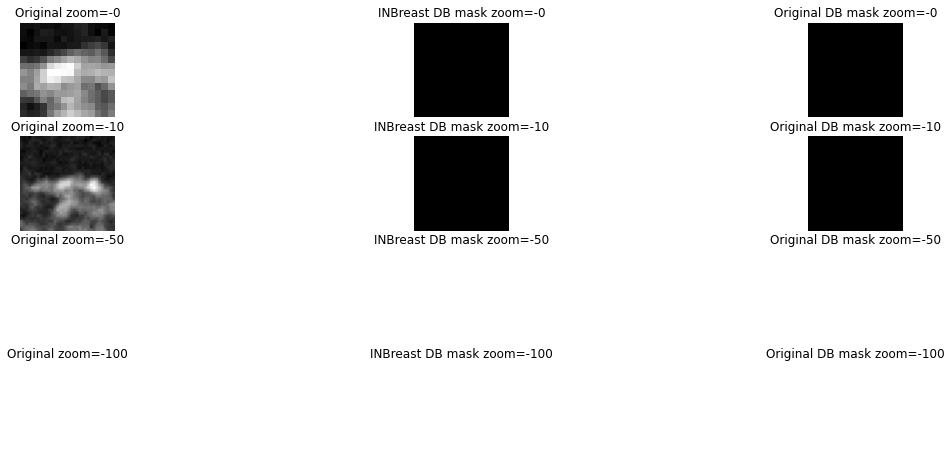

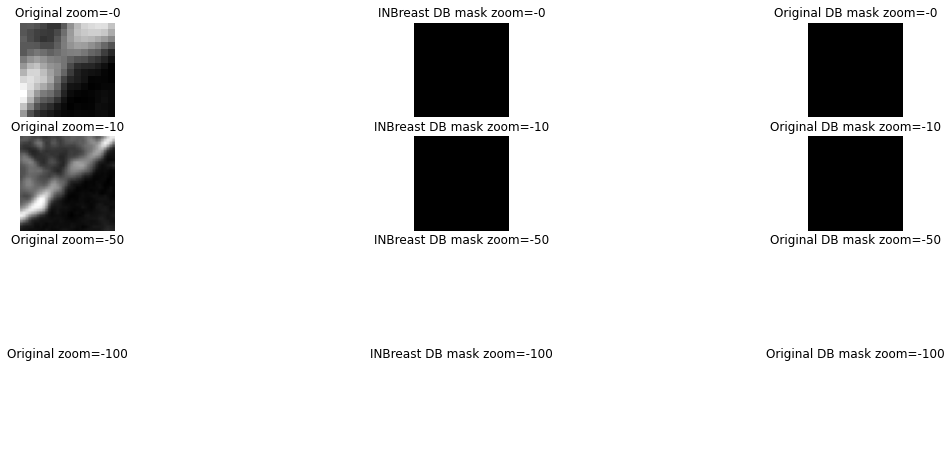

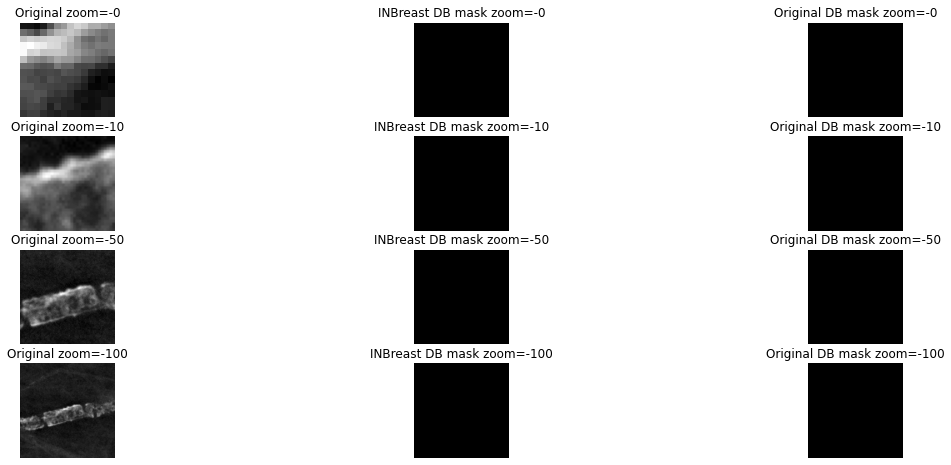

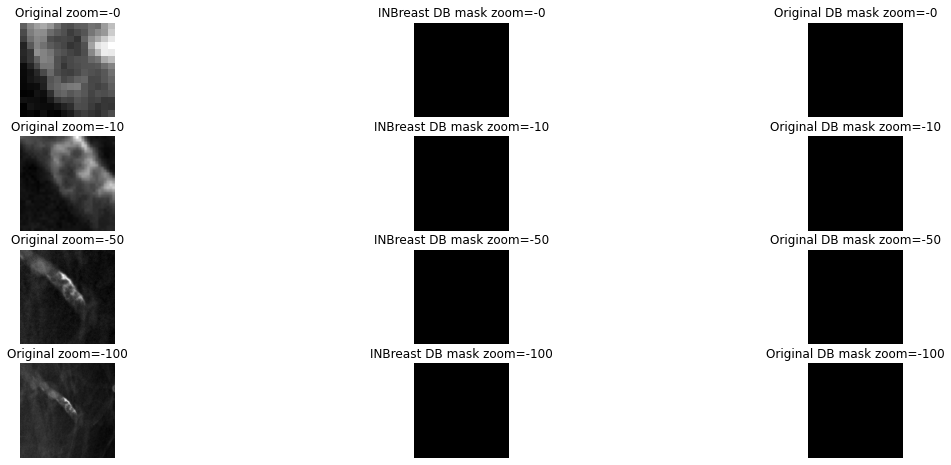

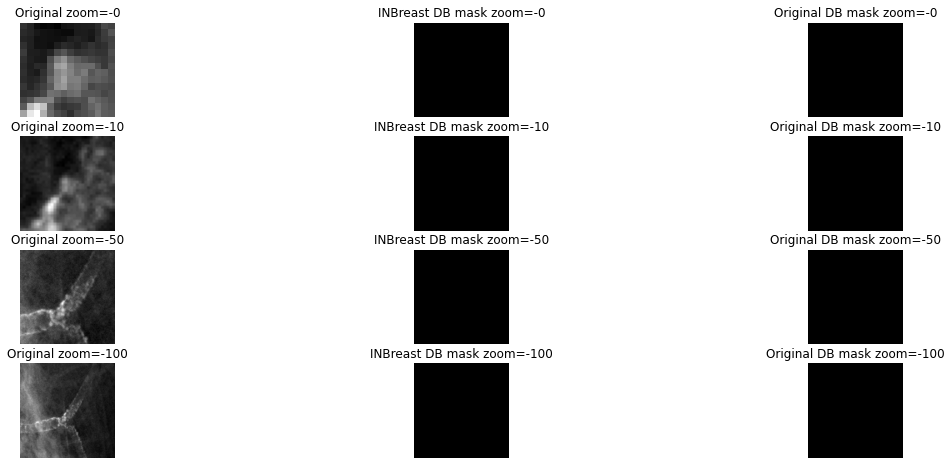

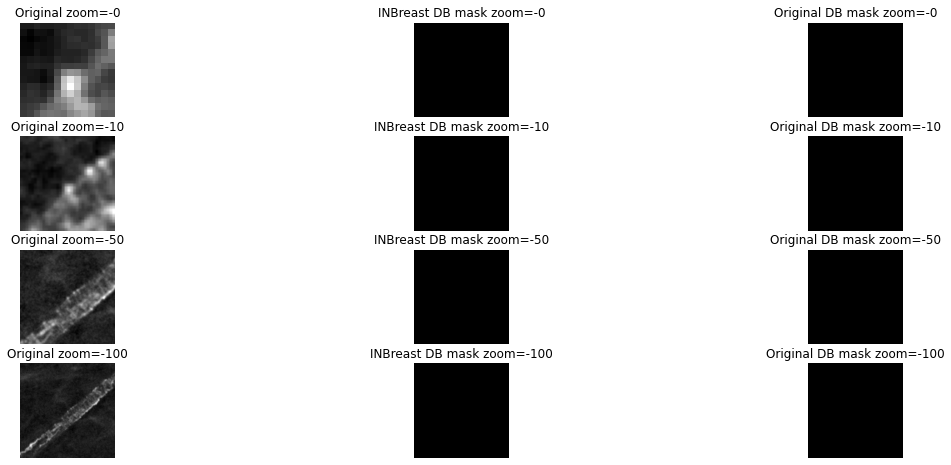

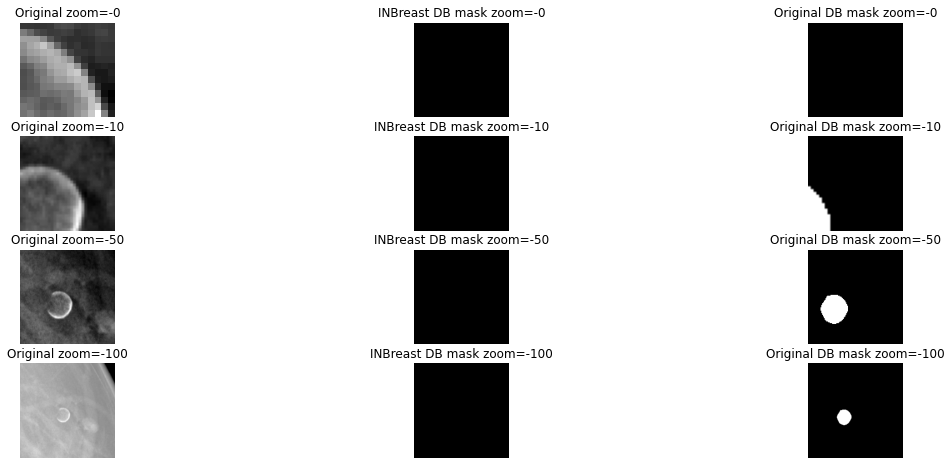

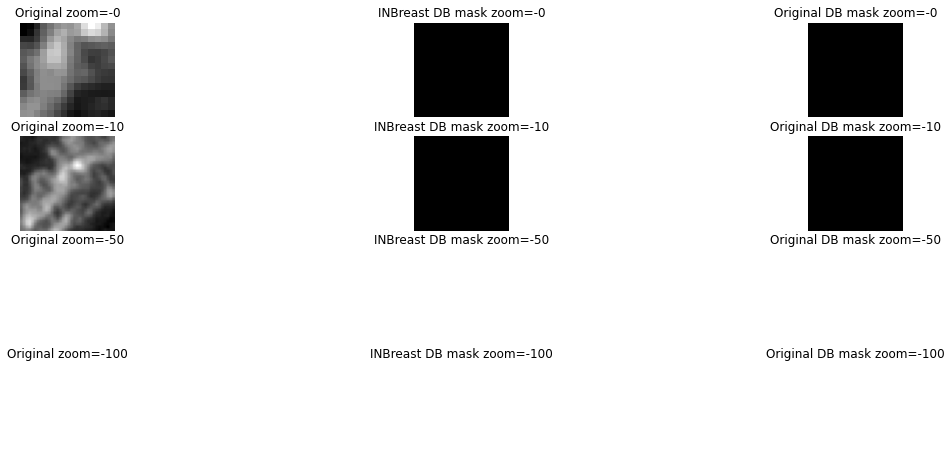

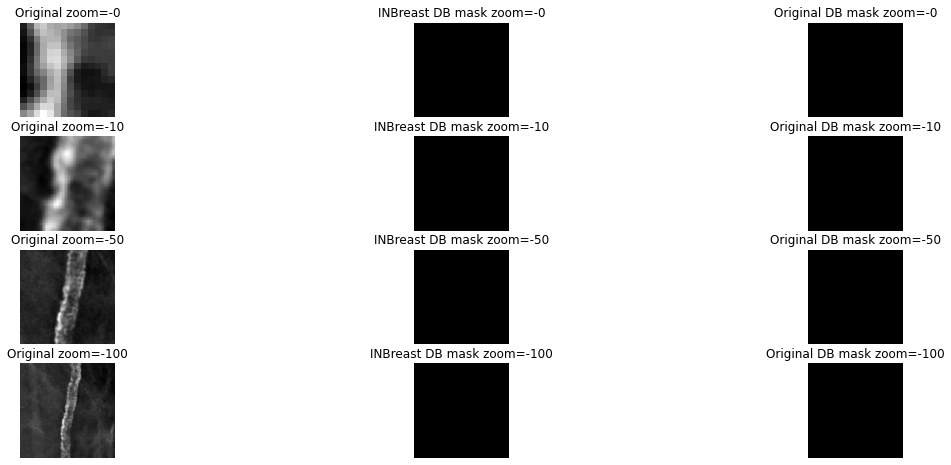

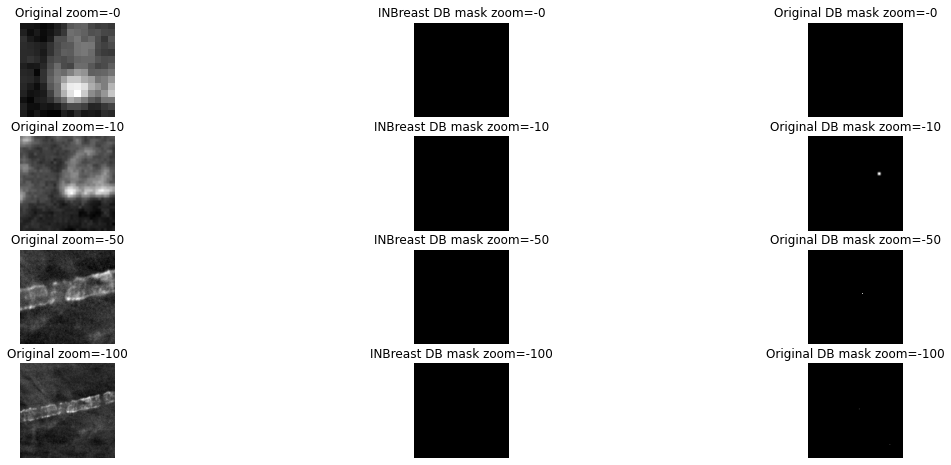

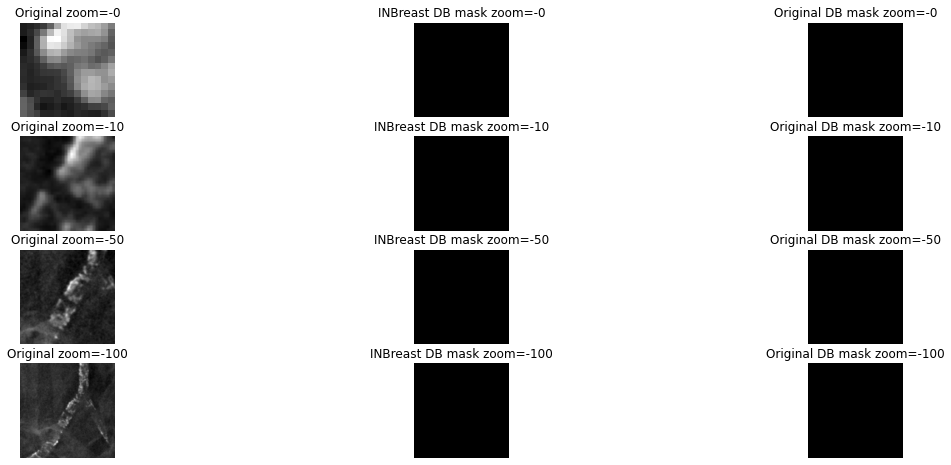

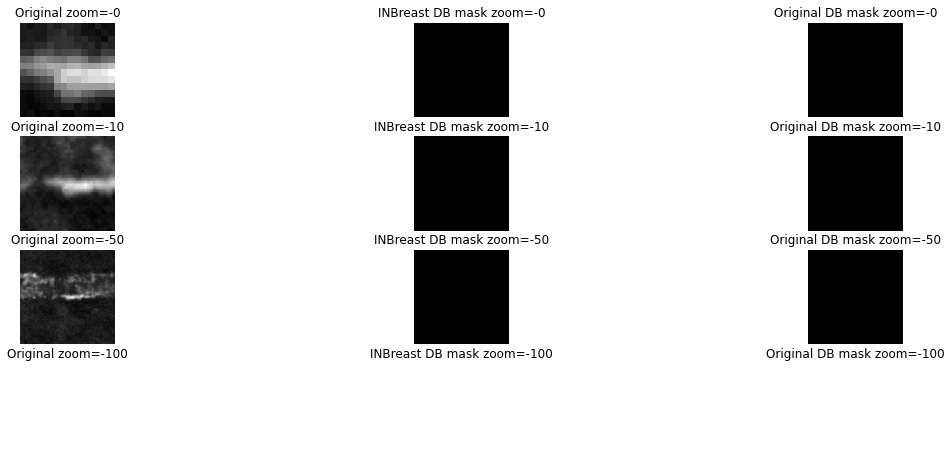

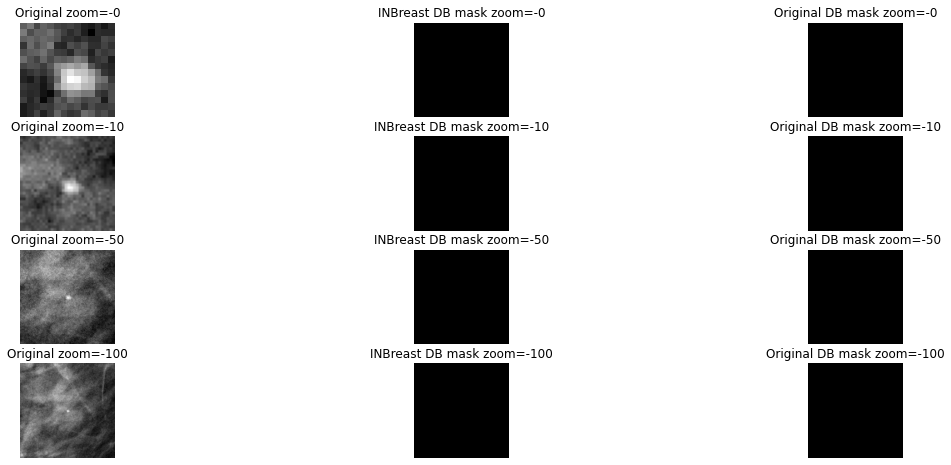

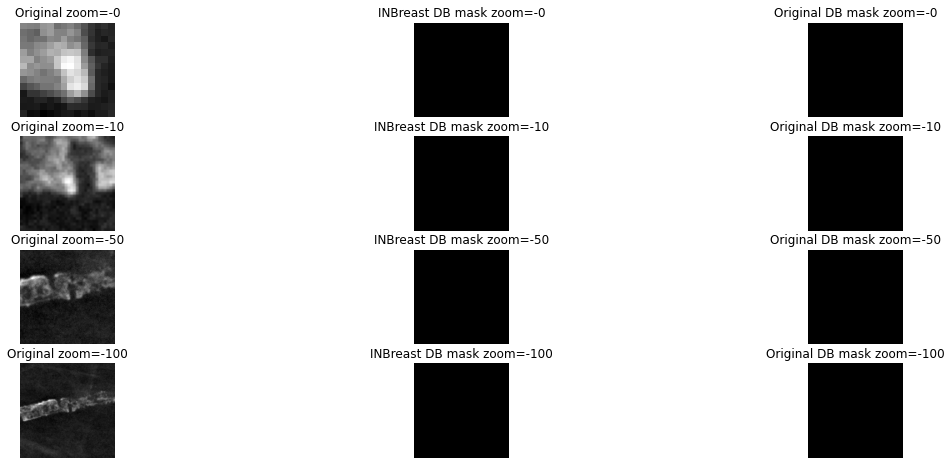

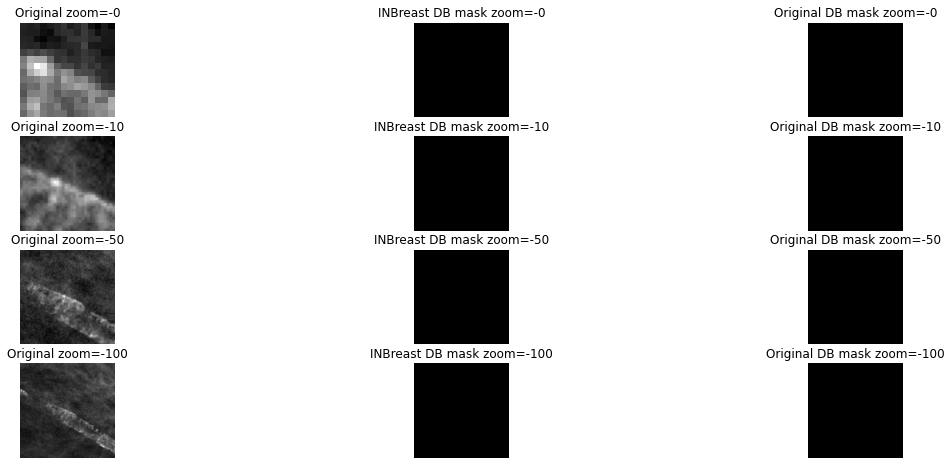

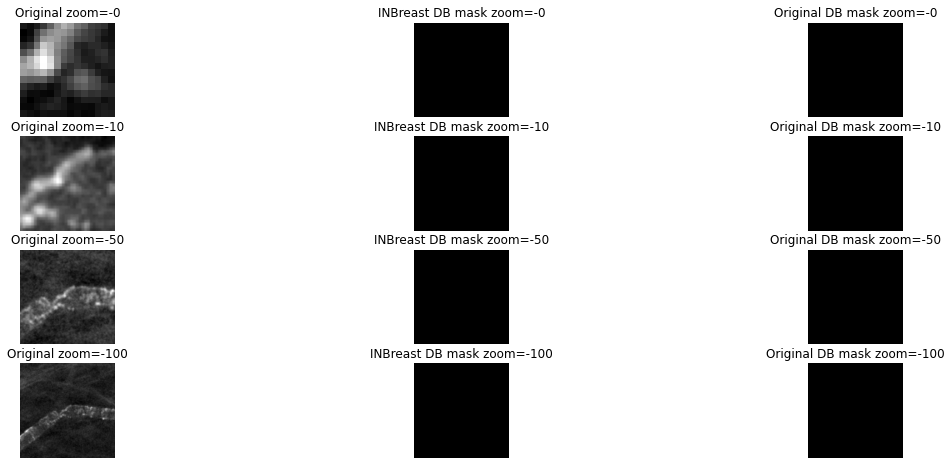

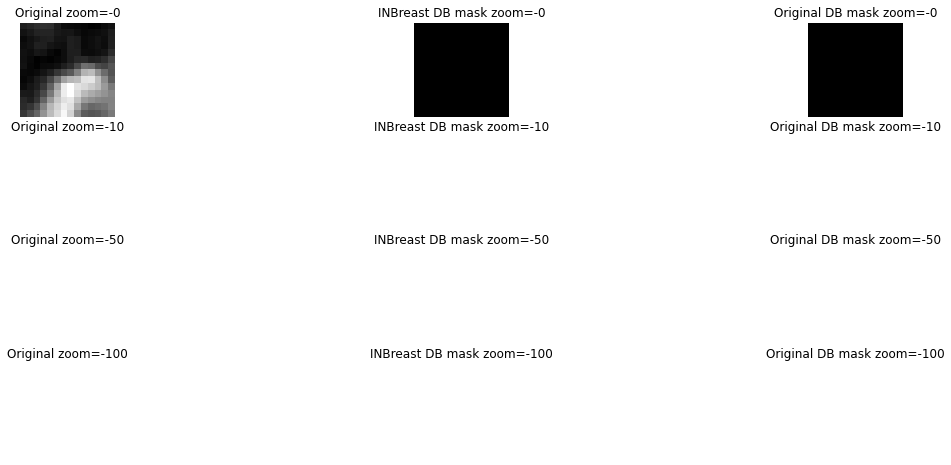

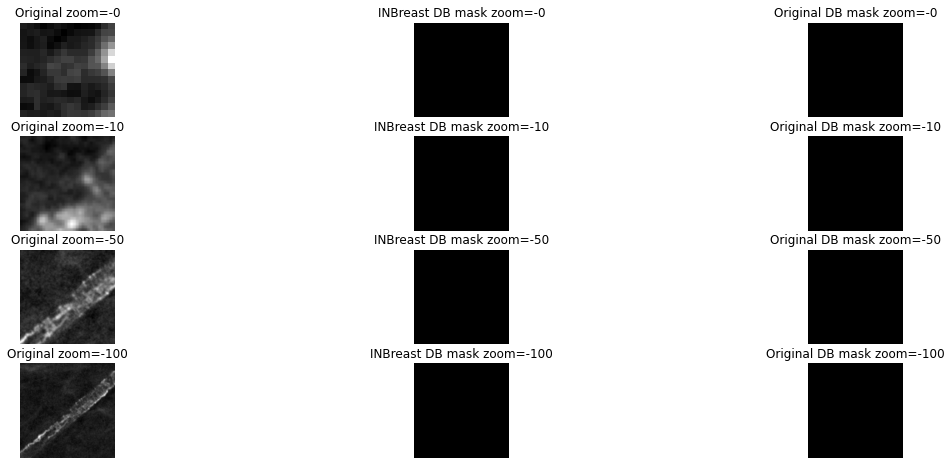

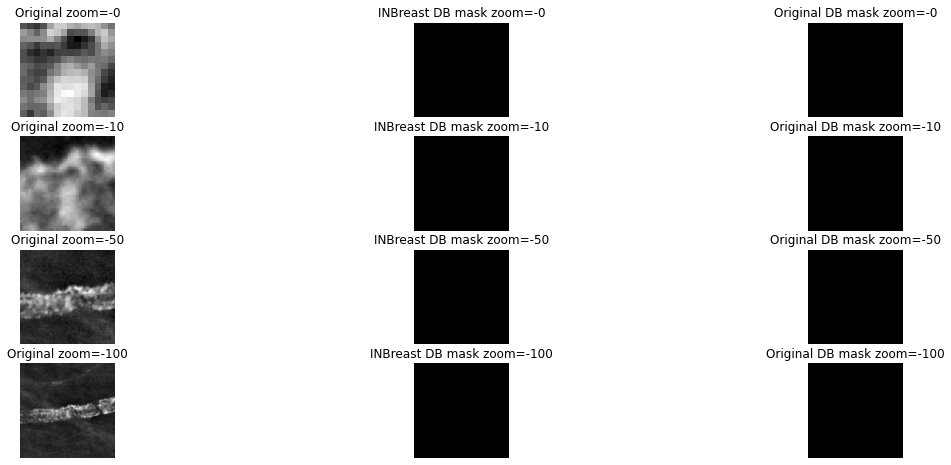

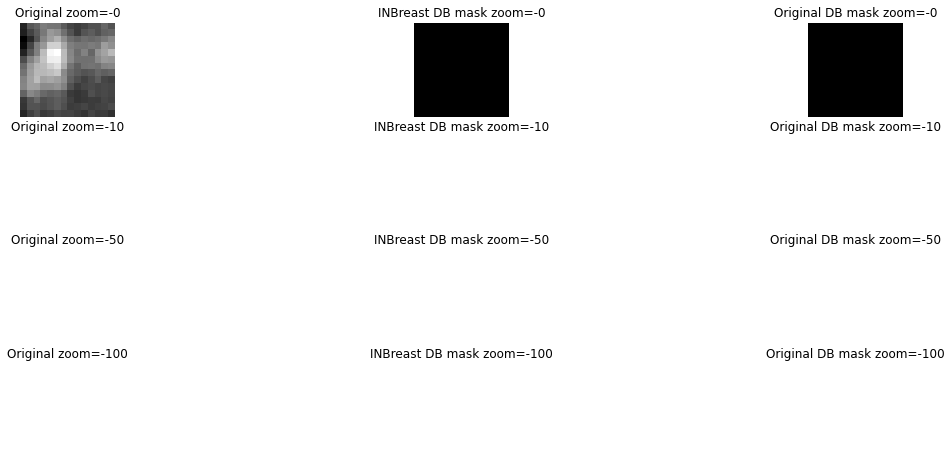

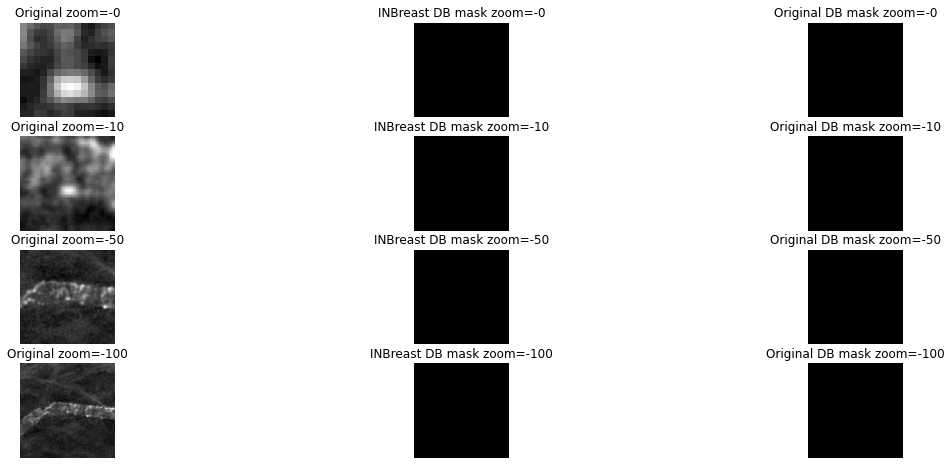

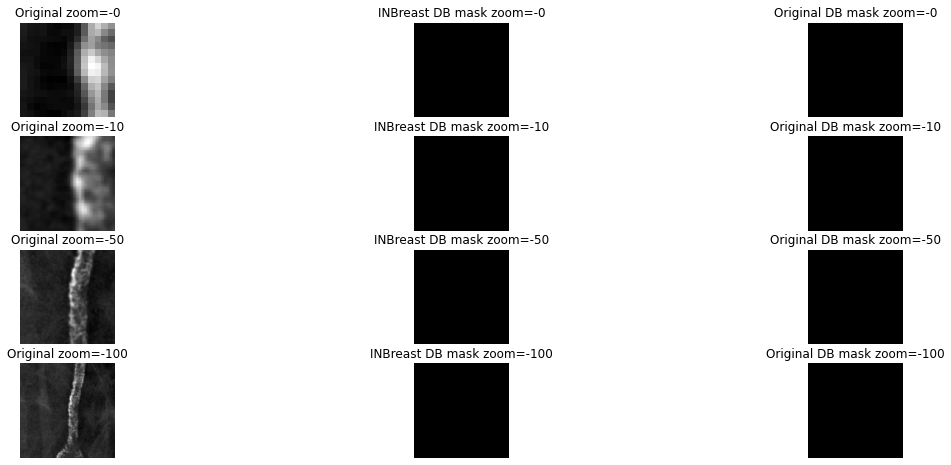

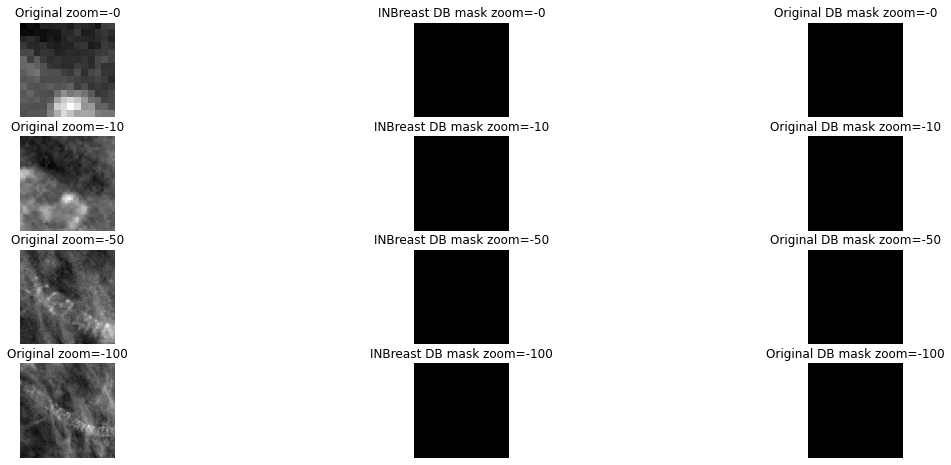

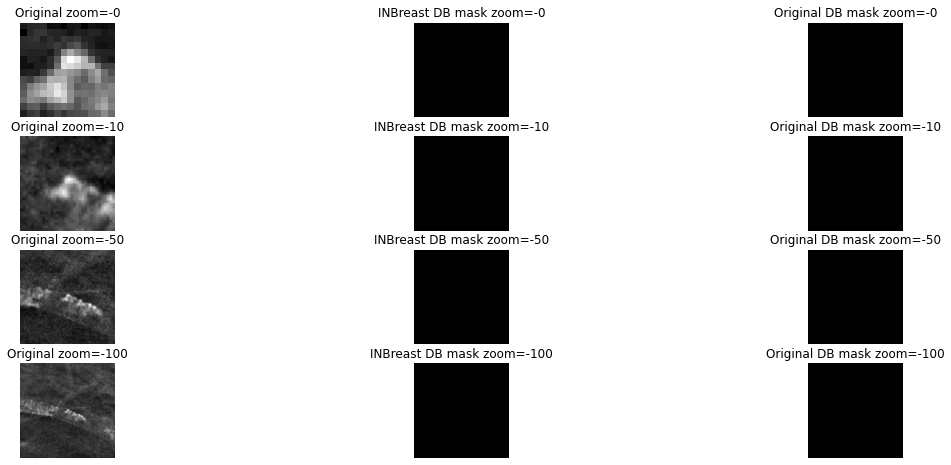

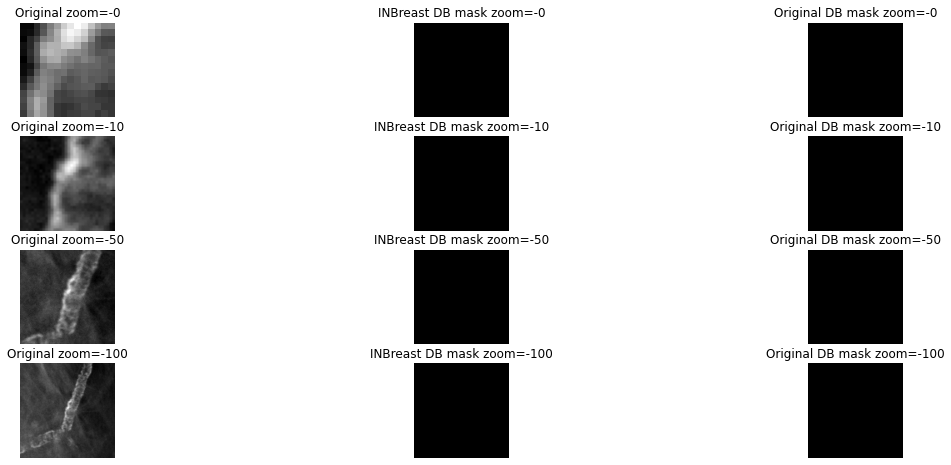

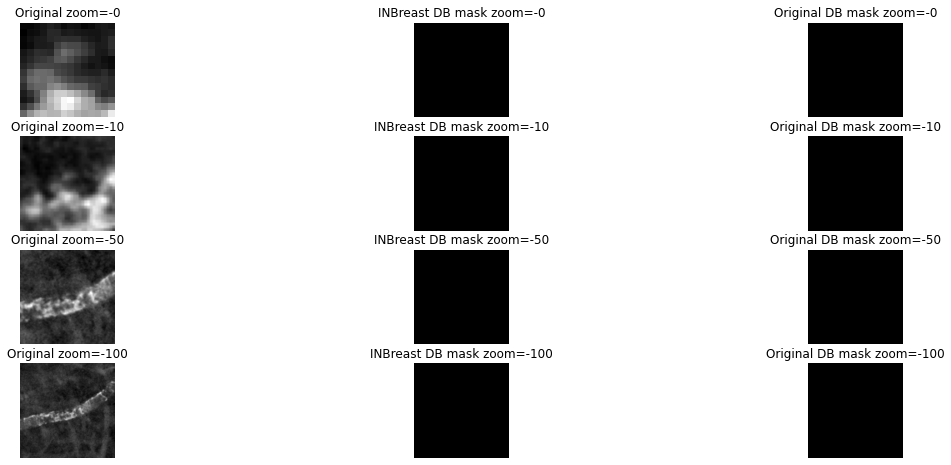

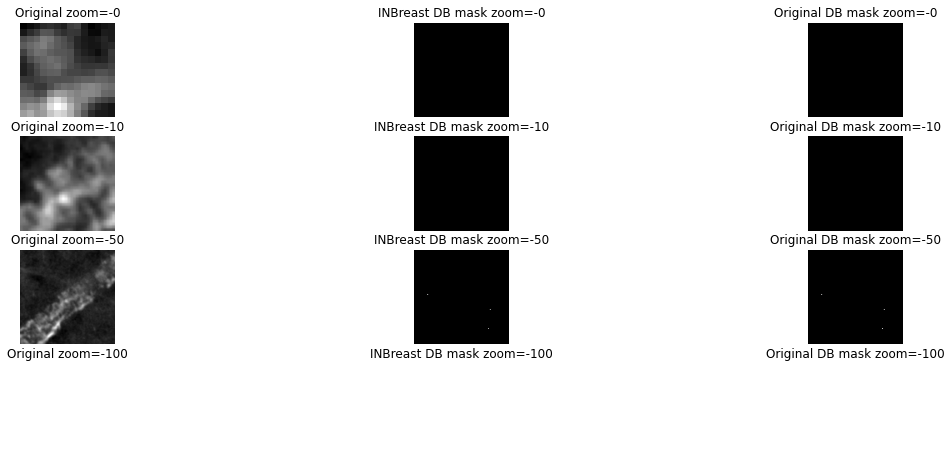

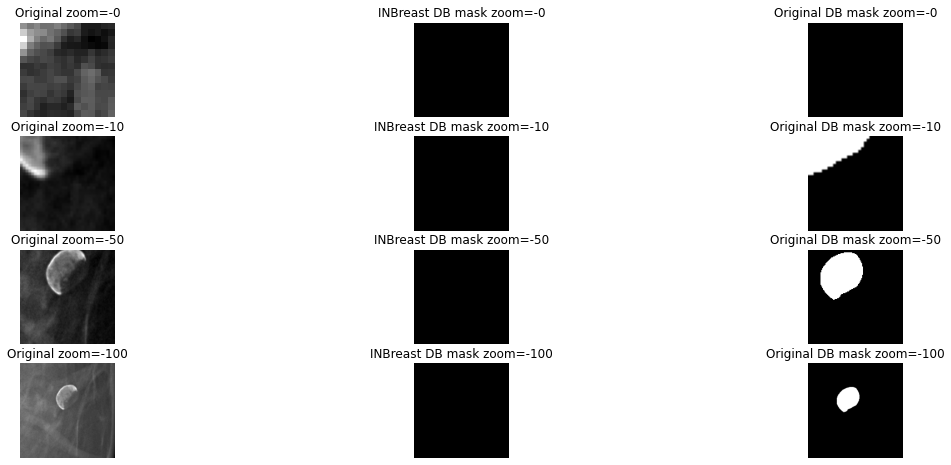

In [37]:

for _, bad_res in tqdm(bads_df.head(100).iterrows(), total=100):
    img_id = bad_res['img_id']
    test_img_id = db.df[db.df.img_id == img_id].index.values[0] #((2767, 2781), (1029, 1043))	
    test_img = db[test_img_id]['img']
    test_mask = db[test_img_id]['lesion_mask']
    original_test_mask = cv2.imread(str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
    (ppx1, ppx2), (ppy1, ppy2)= bad_res['patch_coordinates']


    fig, axs = plt.subplots(4,3, figsize=(20, 8))

    for didx, delta in enumerate([0, 10, 50, 100]):
        axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
        axs[didx, 0].axis('off')
        axs[didx, 0].set_title(f'Original zoom=-{delta}')

        axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], cmap='gray', vmin=0)
        axs[didx, 1].axis('off')
        axs[didx, 1].set_title(f'INBreast DB mask zoom=-{delta}')

        axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0, cmap='gray', vmin=0)
        axs[didx, 2].axis('off')
        axs[didx, 2].set_title(f'Original DB mask zoom=-{delta}')
    plt.savefig(f'bad_results/conf={bad_res["confidence"]}_{img_id}_{_}.jpg', bbox_inches="tight", dpi=600, pad_inches=0, transparent=False)
    # plt.close(fig)

Two problems persist:
1. mC are labeled as big cluster
    * We need to consider clusters in INBreast db and let them pass size filter
2. mC are not labeled at all
    * Clustering and our labelling for clean pos/neg split used for final training